# Explore differential expression analysis results

In [2]:
import os,sys
import numpy as np
import anndata
import pandas as pd
import mudata as md
import scanpy as sc
import glob
from tqdm import tqdm
import scipy

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pymde
import torch
import re
import hdbscan
import colorsys

import matplotlib.cm as cm
import matplotlib.colors as mcolors 

from sklearn.cluster import DBSCAN
from sklearn.manifold import SpectralEmbedding

from copy import deepcopy

sys.path.append('../3_DE_analysis/')
from DE_analysis_utils import *

pd.set_option('display.max_rows', 100)

In [3]:
datadir = '/Users/rzhu/Gladstone Dropbox/Ronghui Zhu/GRNPerturbSeq/3_expts/processed_data/CD4i_final'
experiment_name = 'CD4i_final'

## Read best DE results

In [4]:
adata_de = sc.read_h5ad(datadir + f'/DE_results_all_confounders/{experiment_name}.merged_DE_results.h5ad')

In [5]:
adata_de.layers['zscore'] = adata_de.layers['log_fc'] / adata_de.layers['lfcSE']
adata_de.layers['zscore'][np.where(adata_de.layers['zscore'] > 50)] = 50

In [6]:
de_counts = get_de_stats(adata_de, effect_col='zscore', signif_col='adj_p_value', alpha=0.1)

In [650]:
mask = (de_counts.n_total_de_genes>30) & (de_counts.n_cells_target>50)
#mask = mask | de_counts.target_name.isin(list(correlation_matrix.loc[hdbscan_labels==4].index.str[9:]))
adata_de_subset = adata_de[mask].copy()

In [1059]:
mask = (adata_de_subset.obs.culture_condition=='Rest')# | (adata_de_subset.obs.culture_condition=='Stim48hr')
adata_de_final = adata_de_subset[mask].copy()
adata_de_final.X = np.nan_to_num(adata_de_final.layers['zscore'], 0)
#adata_de_final.X[adata_de_final.layers['adj_p_value']>0.2] = 0

In [1060]:
#sc.pp.scale(adata_de_final)
mde_2d = pymde.preserve_neighbors(
    data=adata_de_final.X,
    embedding_dim=20,
    n_neighbors=10,
    repulsive_fraction=10,
).embed(verbose=False)
embedding = mde_2d.numpy()
#hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=4) # Tune these parameters
#hdbscan_labels = hdbscan_clusterer.fit_predict(embedding)
#adata_de_final.obs['hdbscan_labels'] = hdbscan_labels.astype(str)

In [1061]:
adata_de_final.obsm['X_mde'] = embedding
#sc.pp.scale(adata_de_final)
#sc.pp.pca(adata_de_final)
sc.pp.neighbors(adata_de_final, n_neighbors=5, use_rep='X_mde')
sc.tl.umap(adata_de_final, min_dist=0.2)#, init_pos='X_mde')

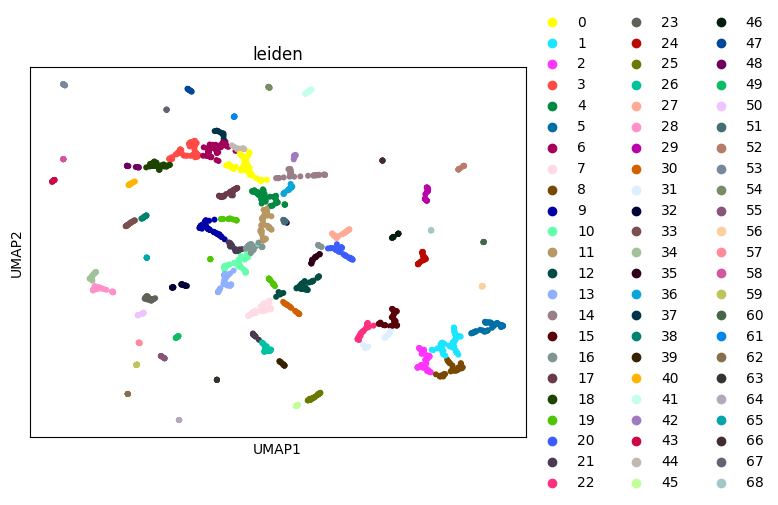

In [1062]:
sc.tl.leiden(adata_de_final, resolution=1.5)
sc.pl.umap(adata_de_final, color=['leiden'])

In [907]:
adata_de_final

AnnData object with n_obs × n_vars = 3224 × 13959
    obs: 'target_contrast_gene_name', 'culture_condition', 'target_contrast', 'chunk', 'n_cells_target', 'leiden'
    var: 'gene_ids', 'gene_name', 'mean', 'std'
    uns: 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_mde', 'X_umap'
    layers: 'adj_p_value', 'baseMean', 'lfcSE', 'log_fc', 'p_value', 'zscore'
    obsp: 'distances', 'connectivities'

In [1064]:
i = 28
j = 5
test = pd.DataFrame(data=np.concatenate([adata_de_final[adata_de_final.obs.leiden==str(i)].X.toarray(),
                                         adata_de_final[adata_de_final.obs.leiden==str(j)].X.toarray()]),
                    index=adata_de_final[adata_de_final.obs.leiden==str(i)].obs.target_contrast_gene_name.values.tolist()+\
                    adata_de_final[adata_de_final.obs.leiden==str(j)].obs.target_contrast_gene_name.values.tolist(),
                    columns=adata_de_final.var.gene_name)

In [1065]:
test2 = test.T.corr().values
np.fill_diagonal(test2, 0)

<Axes: >

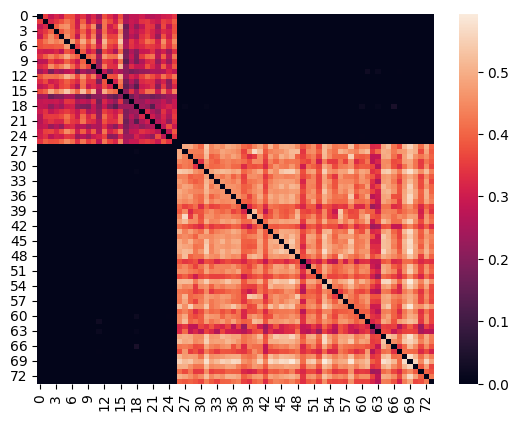

In [1066]:
sns.heatmap(test2, vmin=0)

In [1063]:
adata_de_final[adata_de_final.obs.target_contrast_gene_name=='COX11'].obs

target_contrast_gene_name culture_condition  \
ENSG00000166260_Rest                     COX11              Rest   

                      target_contrast chunk  n_cells_target leiden  
ENSG00000166260_Rest  ENSG00000166260   605           150.0     28

In [1]:
adata_de_final[adata_de_final.obs.leiden=='28'].obs.sort_values(by='target_contrast_gene_name')

NameError: name 'adata_de_final' is not defined

In [902]:
adata_de_final[adata_de_final.obs.leiden=='22'].obs.target_contrast_gene_name.tolist()

['VARS2',
 'TARS2',
 'MRPS11',
 'EARS2',
 'MRPL37',
 'MRPS26',
 'MRPS25',
 'MRPL21',
 'MRPS9',
 'MRPL2',
 'RDH13',
 'NSUN4',
 'MIPEP',
 'POLRMT',
 'MRPS27',
 'LARS2',
 'MRPL45',
 'COX6C',
 'MRPS2',
 'PARS2',
 'SSBP1',
 'COX6B1',
 'HSD17B10',
 'SCO1',
 'SCO2',
 'COX11',
 'MRPS16',
 'MRPS24',
 'MRPS35',
 'MYCN']

In [128]:
trans_effects_df_all = pd.DataFrame(data=adata_de_final.layers['zscore'],
                                columns=adata_de_final.var.gene_name,
                                index=adata_de_final.obs.culture_condition.str.cat(
                                    adata_de_final.obs.target_contrast_gene_name, sep='_', na_rep=''))
trans_effects_df_all = trans_effects_df_all.fillna(0)

In [ ]:
correlation_matrix = trans_effects_df_all.T.corr()
np.fill_diagonal(correlation_matrix.values, 0)
correlation_matrix.max(0).hist(bins=30)

In [ ]:
# Filter by fraction of shared effects and keep top JI pairs
JI_thresh = 0.4

keep_tests = correlation_matrix.max(0) > JI_thresh
correlation_matrix = correlation_matrix.loc[keep_tests, keep_tests]
order_perts = correlation_matrix.sum(0).sort_values(ascending=False).index.tolist()
ordered_data = correlation_matrix.loc[order_perts, order_perts]

# First generate clustermap to get ordering
clustermap = sns.clustermap(
    ordered_data,
    method='ward', metric='euclidean',
    figsize=(25,25), 
    xticklabels=True, yticklabels=True,
    cmap='magma',
    vmax=0.8,
    vmin=0
)

# Get the row and column ordering from the clustermap
row_order = clustermap.dendrogram_row.reordered_ind
col_order = clustermap.dendrogram_col.reordered_ind
reordered_data = ordered_data.iloc[row_order, col_order]

In [174]:
X = trans_effects_df_all.values
# We compute a 2-dimensional spectral embedding for initialization.
spectral_2d_init_np = SpectralEmbedding(n_components=2, n_neighbors=5, eigen_solver='arpack', random_state=42).fit_transform(X)
spectral_2d_init = torch.tensor(spectral_2d_init_np).contiguous()
# We use the same high-level function to create the 2D embedding object.
mde_2d = pymde.preserve_neighbors(
    data=X,
    embedding_dim=2,
    n_neighbors=5,
    repulsive_fraction=7,
).embed(X=spectral_2d_init, eps=1e-06, max_iter=3000, verbose=True)
embedding_np = mde_2d.numpy()

Jul 23 02:38:34 PM: Fitting a centered embedding into R^2, for a graph with 1713 items and 58768 edges.
Jul 23 02:38:34 PM: `embed` method parameters: eps=1.0e-06, max_iter=3000, memory_size=10
Jul 23 02:38:34 PM: iteration 0000 | distortion 6.789090 | residual norm 132.944 | step length 0.000181481 | percent change 3.42361
Jul 23 02:38:36 PM: iteration 0300 | distortion 0.119424 | residual norm 0.00020087 | step length 1 | percent change 0.288748
Jul 23 02:38:38 PM: iteration 0600 | distortion 0.116729 | residual norm 0.000138191 | step length 0.479603 | percent change 1.17813
Jul 23 02:38:40 PM: iteration 0900 | distortion 0.115750 | residual norm 2.43385e-05 | step length 1 | percent change 0.0156082
Jul 23 02:38:41 PM: iteration 1200 | distortion 0.115738 | residual norm 2.00679e-05 | step length 1 | percent change 0.151045
Jul 23 02:38:43 PM: iteration 1500 | distortion 0.115387 | residual norm 3.77906e-05 | step length 1 | percent change 0.0549971
Jul 23 02:38:44 PM: iteration 18

In [220]:
hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=5) # Tune these parameters
hdbscan_labels = hdbscan_clusterer.fit_predict(embedding_np)
hdbscan_labels = np.max(hdbscan_labels) - hdbscan_labels

/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



In [221]:
pymde_df = pd.DataFrame(data=embedding_np,
                        columns=['pyMDE_1', 'pyMDE_2'],
                        index=trans_effects_df_all.index)

pymde_df['cluster'] = hdbscan_labels
pymde_df['timepoint'] = {}
pymde_df.loc[pymde_df.index.str.startswith('Rest_'),'timepoint'] = 'Rest'
pymde_df.loc[pymde_df.index.str.startswith('Stim48hr_'),'timepoint'] = 'Stim48hr'

In [217]:
test = pymde_df.iloc[np.random.permutation(1423)]

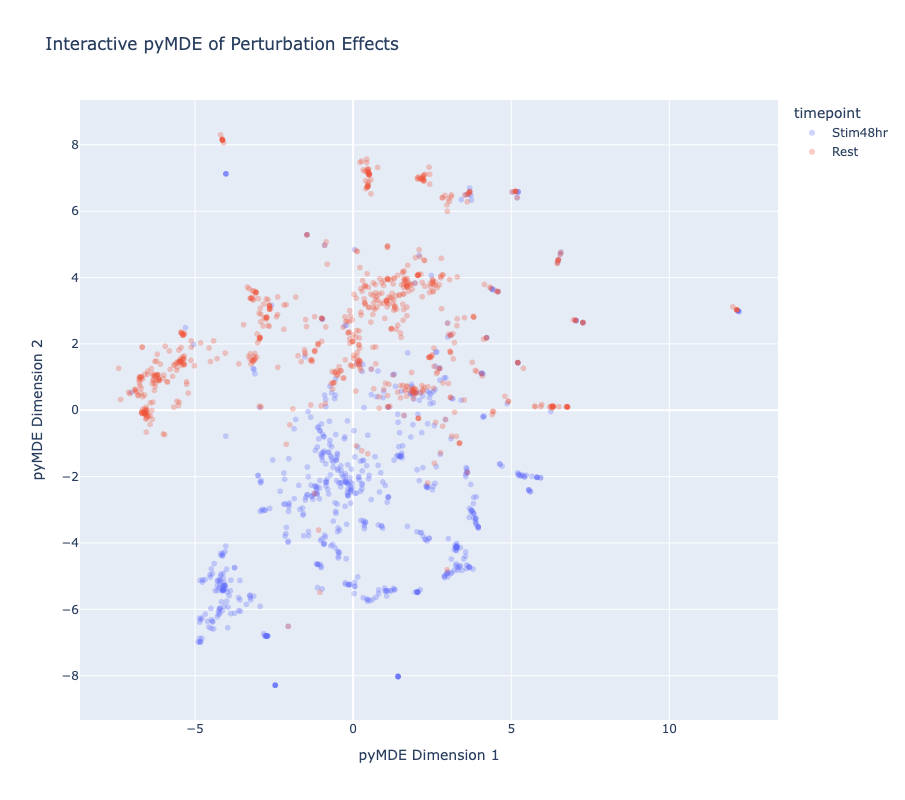

In [273]:
# 4. Visualize with Plotly Express for interactivity ✨
fig = px.scatter(
    test,
    x='pyMDE_1',
    y='pyMDE_2',
    color='timepoint',
    hover_name=test.index, 
    title='Interactive pyMDE of Perturbation Effects',
    width=800,
    height=800,
    opacity=0.3,
)

# Update layout for a cleaner look
fig.update_layout(
    xaxis_title="pyMDE Dimension 1",
    yaxis_title="pyMDE Dimension 2"
)

# Show the interactive plot
fig.show()

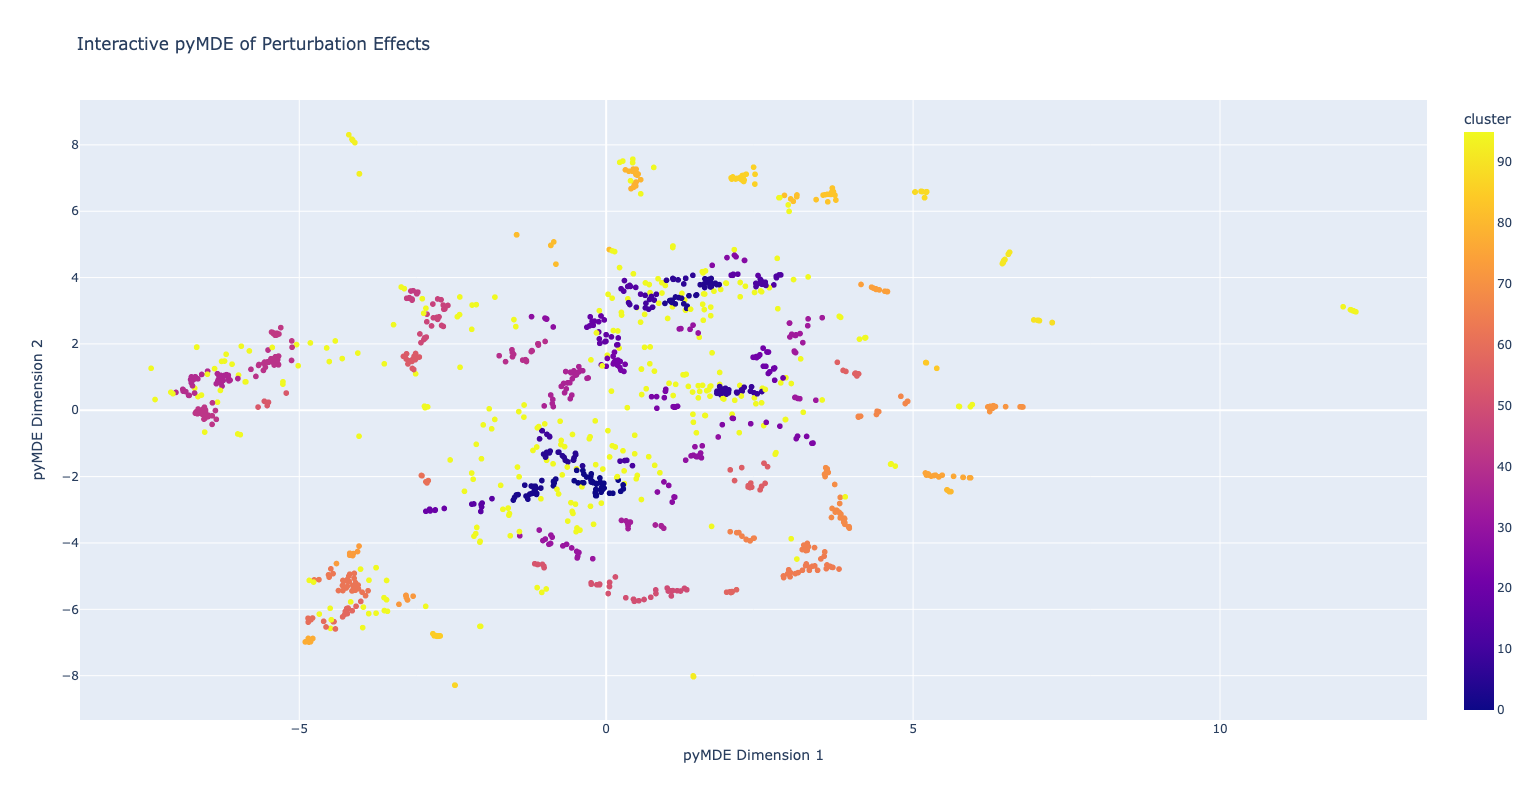

In [206]:
# 4. Visualize with Plotly Express for interactivity ✨
fig = px.scatter(
    test,
    x='pyMDE_1',
    y='pyMDE_2',
    color='cluster',
    hover_name=test.index, 
    title='Interactive pyMDE of Perturbation Effects',
    width=800,
    height=800,
    opacity=1,
)

# Update layout for a cleaner look
fig.update_layout(
    xaxis_title="pyMDE Dimension 1",
    yaxis_title="pyMDE Dimension 2"
)

# Show the interactive plot
fig.show()

In [ ]:
pymde_df.loc['Stim48hr_ELP4']

In [76]:
gene_test = ['TAF6L', 'TADA1', 'CHD7', 'SGF29', 'SUPT20H', 'SENP5', 'MED12', 'MED19', 'CCNC']
'Rest_CD3G', 'Rest_PLCG1', 'Rest_PTPRC', 'Rest_HELT', 'Rest_CD28',
       'Rest_MALT1', 'Rest_TMX1', 'Rest_VAV1', 'Rest_BCL10', 'Rest_ANKRD61',
       'Rest_ITK', 'Rest_CARMIL2', 'Rest_LAT'
gene_test_rest = ['Rest_' + gene for gene in gene_test]
gene_test_stim48hr = ['Stim48hr_' + gene for gene in gene_test]
gene_to_choose = gene_test_rest + gene_test_stim48hr
corr_subset = correlation_matrix.loc[gene_to_choose, gene_to_choose]
np.fill_diagonal(corr_subset.values, 1)

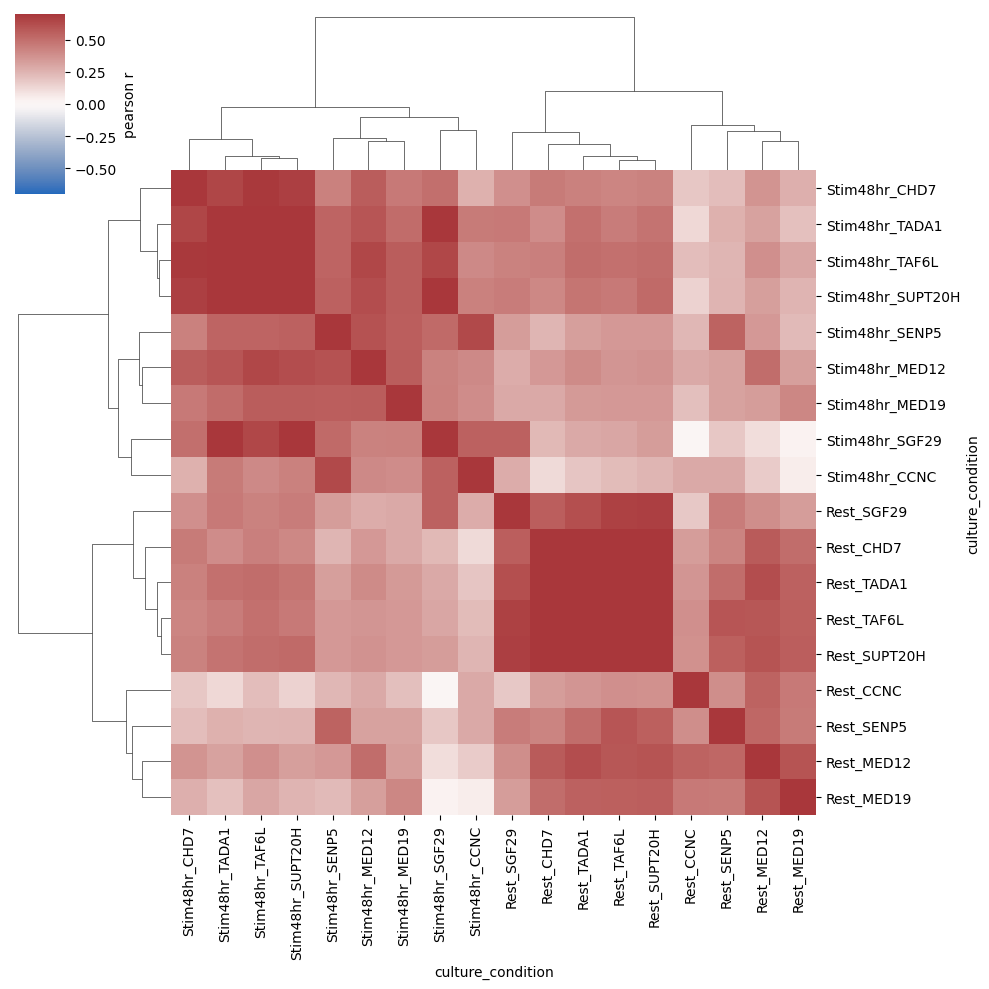

In [77]:
sns.clustermap(
    corr_subset,
    method='ward', metric='euclidean',
    figsize=(10,10), 
    xticklabels=True, yticklabels=True,
    cmap='vlag',
    vmax=0.7,
    vmin=-0.7,
    cbar_kws={'label': 'pearson r'}
)
plt.savefig('results/CD4i_rest_vs_stim48hr_MDE_exp_clusters2.png')

In [104]:
'Rest_' + correlation_matrix.loc[hdbscan_labels==4].index.str[9:]

Index(['Rest_CD3G', 'Rest_PLCG1', 'Rest_PTPRC', 'Rest_HELT', 'Rest_CD28',
       'Rest_MALT1', 'Rest_TMX1', 'Rest_VAV1', 'Rest_BCL10', 'Rest_ANKRD61',
       'Rest_ITK', 'Rest_CARMIL2', 'Rest_LAT'],
      dtype='object', name='culture_condition')

In [219]:
correlation_matrix.loc[hdbscan_labels==84].index

Index(['Stim48hr_MED14', 'Rest_ARMH3', 'Rest_ECHS1', 'Rest_MED19',
       'Stim48hr_KIAA0391', 'Stim48hr_ZFC3H1', 'Stim48hr_EDC3',
       'Stim48hr_GIGYF2', 'Rest_GNPDA2', 'Rest_NCBP3',
       ...
       'Stim48hr_GNE', 'Rest_ZBTB7A', 'Rest_CAP1', 'Rest_UBXN1', 'Rest_TIMM10',
       'Rest_UBR4', 'Stim48hr_UBR4', 'Stim48hr_HDAC3', 'Rest_SMARCE1',
       'Rest_MUM1'],
      dtype='object', name='culture_condition', length=411)

In [258]:
cluster_to_choose = [70, 76, 93]
gene_to_choose = []
for i in cluster_to_choose:
    gene_to_choose = gene_to_choose + list(correlation_matrix.loc[hdbscan_labels==i].index)
#gene_to_choose = gene_to_choose + list('Rest_' + correlation_matrix.loc[hdbscan_labels==35].index.str[9:])
corr_subset = correlation_matrix.loc[gene_to_choose, gene_to_choose]
np.fill_diagonal(corr_subset.values, 1)

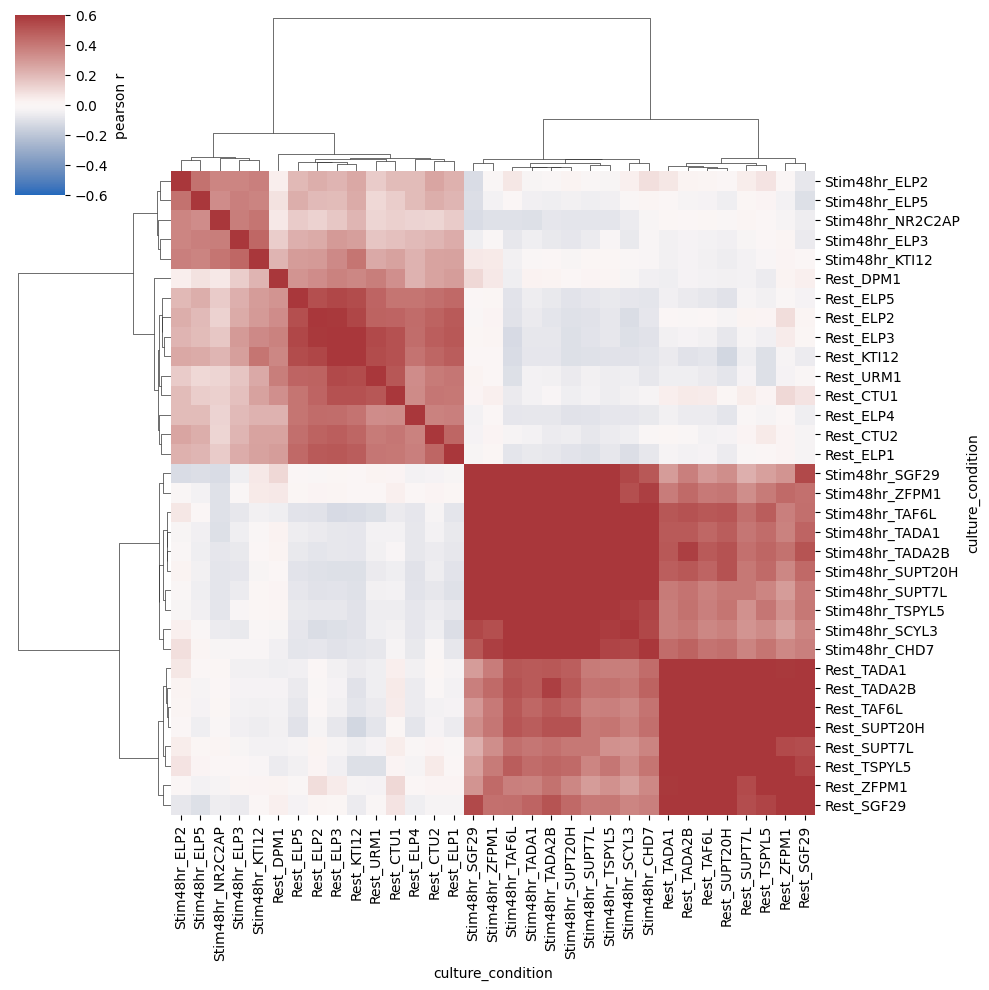

In [259]:
sns.clustermap(
    corr_subset,
    method='ward', metric='euclidean',
    figsize=(10,10), 
    xticklabels=True, yticklabels=True,
    cmap='vlag',
    vmax=0.6,
    vmin=-0.6,
    cbar_kws={'label': 'pearson r'}
)
plt.savefig('results/CD4i_rest_vs_stim48hr_MDE_exp_clusters2.png')

In [268]:
cluster_to_choose = [34, 35]
gene_to_choose = []
for i in cluster_to_choose:
    gene_to_choose = gene_to_choose + list(correlation_matrix.loc[hdbscan_labels==i].index)
gene_to_choose = gene_to_choose + list('Rest_' + correlation_matrix.loc[hdbscan_labels==34].index.str[9:])
gene_to_choose = gene_to_choose + list('Rest_' + correlation_matrix.loc[hdbscan_labels==35].index.str[9:])
gene_to_choose.remove('Rest_FLCN')
corr_subset = correlation_matrix.loc[gene_to_choose, gene_to_choose]
np.fill_diagonal(corr_subset.values, 1)

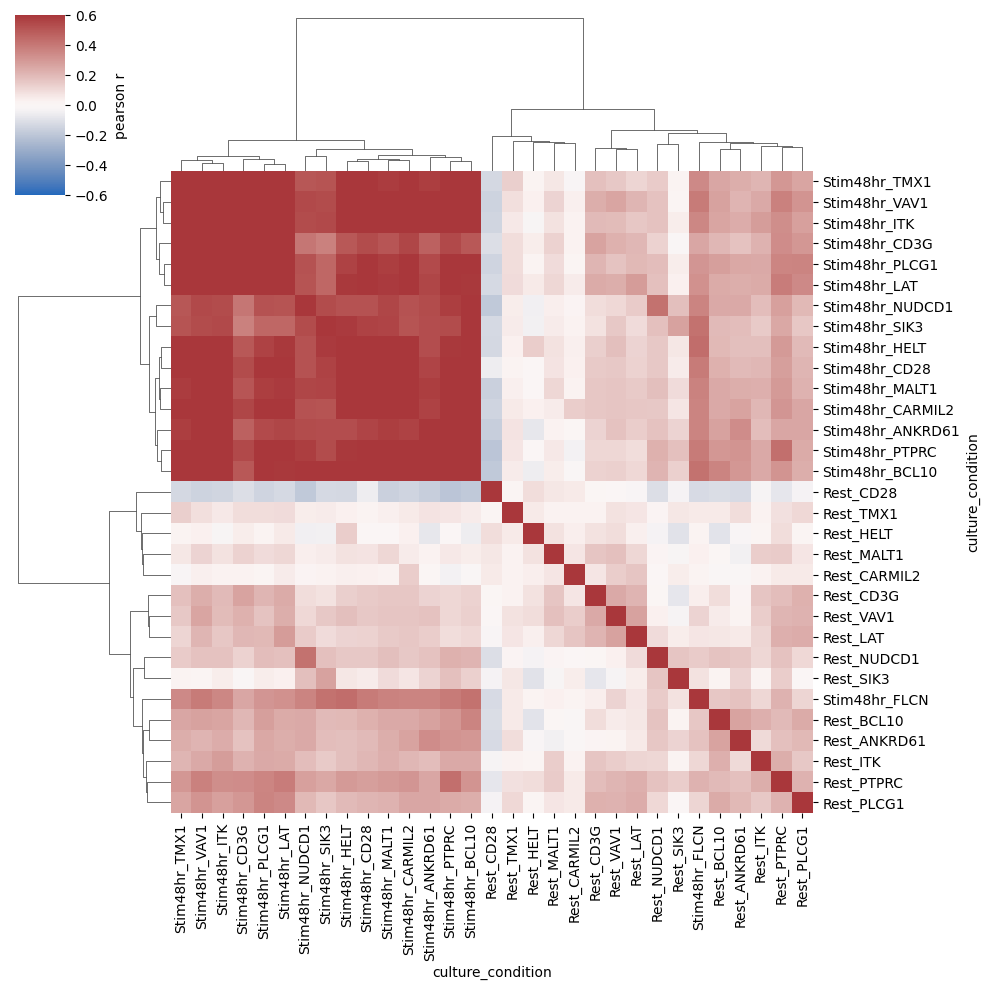

In [270]:
sns.clustermap(
    corr_subset,
    method='ward', metric='euclidean',
    figsize=(10,10), 
    xticklabels=True, yticklabels=True,
    cmap='vlag',
    vmax=0.6,
    vmin=-0.6,
    cbar_kws={'label': 'pearson r'}
)
plt.savefig('results/CD4i_rest_vs_stim48hr_MDE_exp_clusters3.png')

In [271]:
cluster_to_choose = [91, 94]
gene_to_choose = []
for i in cluster_to_choose:
    gene_to_choose = gene_to_choose + list(correlation_matrix.loc[hdbscan_labels==i].index)
corr_subset = correlation_matrix.loc[gene_to_choose, gene_to_choose]
np.fill_diagonal(corr_subset.values, 1)

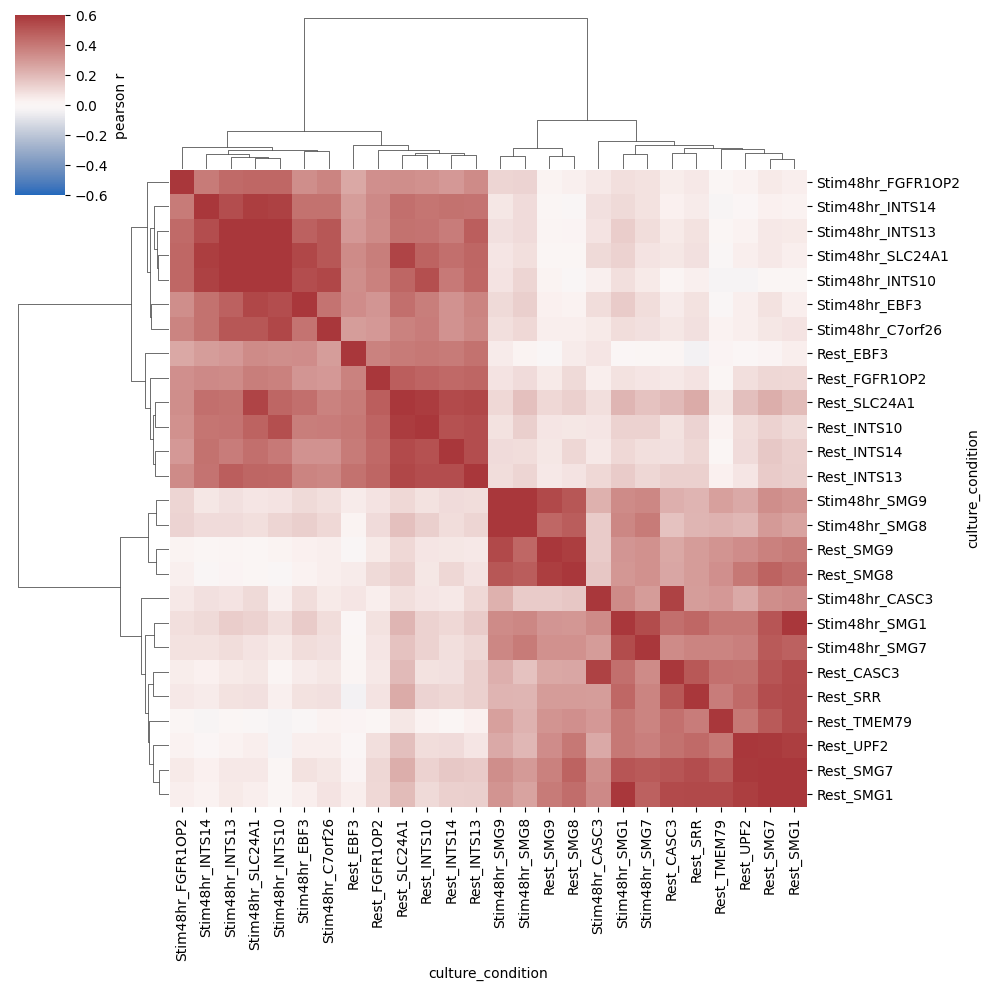

In [272]:
sns.clustermap(
    corr_subset,
    method='ward', metric='euclidean',
    figsize=(10,10), 
    xticklabels=True, yticklabels=True,
    cmap='vlag',
    vmax=0.6,
    vmin=-0.6,
    cbar_kws={'label': 'pearson r'}
)
plt.savefig('results/CD4i_rest_vs_stim48hr_MDE_exp_clusters.png')

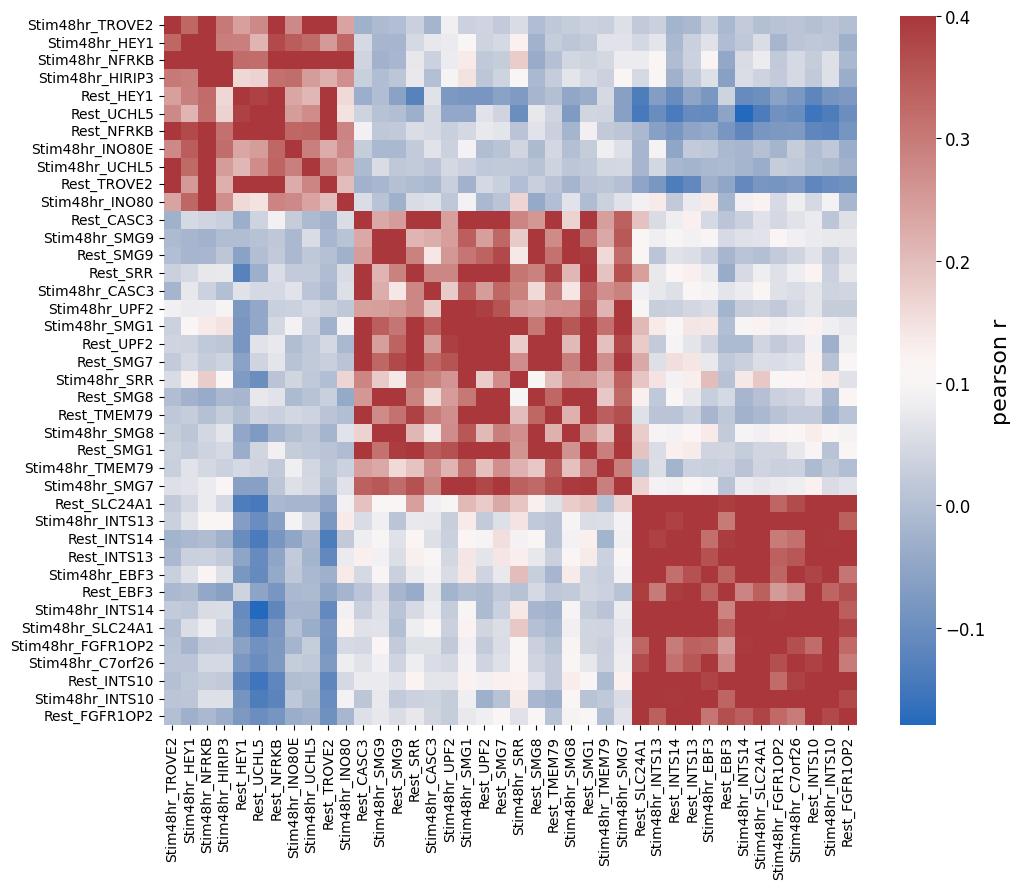

In [34]:
fig, ax = plt.subplots(figsize=(10.5,9))
sns.heatmap(corr_subset, cmap='vlag', vmax=0.4, ax=ax)
ax.set_xlabel('')
ax.set_ylabel('')
cbar = ax.collections[0].colorbar
cbar.ax.set_ylabel("pearson r", fontsize=16)
cbar.ax.tick_params(labelsize=12)
plt.tight_layout()
#plt.savefig('results/CD4i_rest_vs_stim48hr_MDE_exp_clusters.png')

In [96]:
pymde_df[pymde_df.index=='Stim48hr_ELP1']

Empty DataFrame
Columns: [pyMDE_1, pyMDE_2, cluster, timepoint]
Index: []

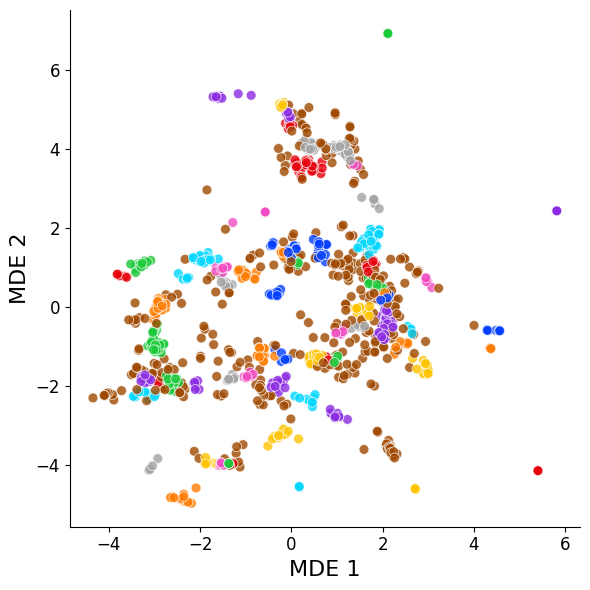

In [283]:
palette = sns.color_palette("bright", n_colors=76)
pymde_df = pd.DataFrame(data=embedding_np,
                        columns=['pyMDE_1', 'pyMDE_2'],
                        index=trans_effects_df.index)

pymde_df['cluster'] = hdbscan_labels

fig, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(
    pymde_df,
    x='pyMDE_1',
    y='pyMDE_2',
    hue='cluster',
    s=50,
    palette=palette,
    legend=False,
    ax=ax,
    alpha=0.8,
)
ax.set_xlabel('MDE 1', fontsize=16)
ax.set_ylabel('MDE 2', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=12)

sns.despine()
plt.tight_layout()
plt.savefig('results/CD4i_stim48hr_MDE.png')

In [286]:
list(correlation_matrix.loc[hdbscan_labels==74].index)

['SLC39A6',
 'ELP4',
 'ELP3',
 'ELP2',
 'ELP1',
 'NR2C2AP',
 'KTI12',
 'URM1',
 'ELP5',
 'CTU1']

In [284]:
cluster_to_choose = [74, 69]
gene_to_choose = []
for i in cluster_to_choose:
    gene_to_choose = gene_to_choose + list(correlation_matrix.loc[hdbscan_labels==i].index)
corr_subset = correlation_matrix.loc[gene_to_choose, gene_to_choose]
np.fill_diagonal(corr_subset.values, 1)

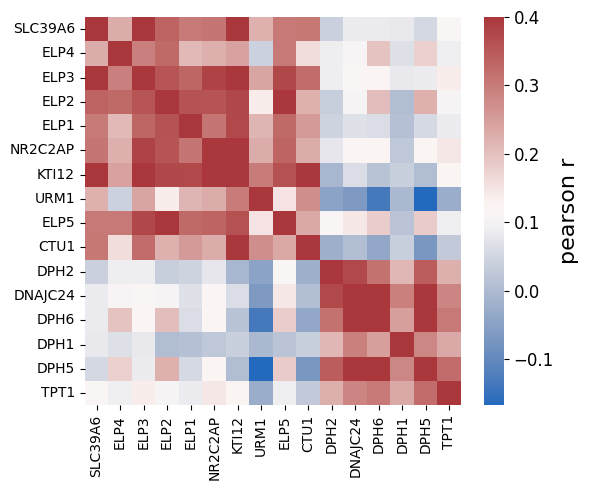

In [285]:
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(corr_subset, cmap='vlag', vmax=0.4, ax=ax)
ax.set_xlabel('')
ax.set_ylabel('')
cbar = ax.collections[0].colorbar
cbar.ax.set_ylabel("pearson r", fontsize=16)
cbar.ax.tick_params(labelsize=12)
plt.tight_layout()
plt.savefig('results/CD4i_stim48hr_MDE_exp_clusters.png')

In [207]:
trans_effects_df

gene_name                    TSPAN6      DPM1     SCYL3  C1orf112       FGR  \
target_contrast_gene_name                                                     
TFAM                       0.016539 -2.493574 -1.382062  0.309703  0.022280   
TMEM131L                  -0.000232 -0.618483  0.639062 -1.368992  0.127923   
SCO1                       0.012868 -2.052571  0.185324  2.150811  0.076685   
TIMM10                    -0.004034  1.996024  1.043490 -1.800677  1.763856   
CNOT11                     0.004888 -0.550703  1.106222 -0.307655  0.227571   
...                             ...       ...       ...       ...       ...   
ADAT2                      0.008201 -2.822576  0.010313 -0.837343  0.114801   
VWF                        0.001106 -0.739607 -0.601908  0.734036  1.581100   
RRAGC                      0.009937 -1.900878 -1.013190  1.088616  0.343102   
ARL1                      -0.007449  0.605314 -0.464445 -0.896051 -0.529305   
BCL11B                     0.008015 -2.809365  0.845148 -0.837134  0.072997   

gene_name                       CFH     FUCA2      GCLC      NFYA     STPG1  \
target_contrast_gene_name                                                     
TFAM                      -0.952095 -0.170667  0.271319  1.516596  1.413445   
TMEM131L                   0.951757  0.031227 -0.473020 -0.802153  0.432187   
SCO1                       0.039965 -0.878841 -1.164959  1.883536 -1.275989   
TIMM10                     1.734332  1.753451 -1.725789  0.342738  1.553592   
CNOT11                     2.087880  0.880159  0.839391 -0.359898  2.441517   
...                             ...       ...       ...       ...       ...   
ADAT2                      0.245393 -1.473888  0.493679 -0.461300  0.084284   
VWF                       -0.138550 -1.220093  0.904119  1.453377  0.808616   
RRAGC                     -0.438931  0.616059  1.449446  0.328717  0.572934   
ARL1                      -0.258558 -0.680403 -0.245868  3.082775  1.893593   
BCL11B                     2.952096  6.188425 -1.634833  0.923351 -1.799464   

gene_name                  ...  ARHGAP11B  LINC02929  CDR1    PRRC2B  \
target_contrast_gene_name  ...                                         
TFAM                       ...   0.831971   0.134255   0.0  1.108696   
TMEM131L                   ...  -1.370980   0.017633   0.0  0.370448   
SCO1                       ...   1.123975   0.103907   0.0 -0.279167   
TIMM10                     ...  -0.942056  -0.037009   0.0  0.169393   
CNOT11                     ...   1.359603   0.072512   0.0  2.480470   
...                        ...        ...        ...   ...       ...   
ADAT2                      ...   0.445666   0.080480   0.0  0.843859   
VWF                        ...   0.264711   0.058239   0.0  0.538246   
RRAGC                      ...   2.080693   0.066905   0.0 -1.554849   
ARL1                       ...   0.840654   0.042474   0.0 -0.141165   
BCL11B                     ...   0.719235   0.067463   0.0  2.531454   

gene_name                      F8A1     HOMEZ  C2orf83  ENSG00000290797  \
target_contrast_gene_name                                                 
TFAM                       0.971723 -0.606550      0.0         0.355100   
TMEM131L                  -1.036686 -0.650869      0.0         0.036041   
SCO1                      -0.350379 -0.459203      0.0         0.979098   
TIMM10                     0.631191  0.727048      0.0        -0.522678   
CNOT11                     0.472072  1.925761      0.0         1.131969   
...                             ...       ...      ...              ...   
ADAT2                     -0.030173 -1.284847      0.0         0.454914   
VWF                        2.066388  2.015161      0.0         1.485159   
RRAGC                      1.725778  1.257580      0.0        -0.113922   
ARL1                      -1.029842 -1.561015      0.0        -0.052859   
BCL11B                    -0.024337 -0.109663      0.0         1.926129   

gene_name                  ENSG

In [206]:
embedding_np.shape

(1215, 2)

In [120]:
hdbscan_labels.shape

(1215,)

In [17]:
gene_obs_df = pd.read_csv('../../2_files/Replogle_et_al_2022/perturbation_clusters.csv', index_col=0)
gene_var_df = pd.read_csv('../../2_files/Replogle_et_al_2022/gex_clusters.csv', index_col=0)

In [12]:
df_list_of_genes = gene_obs_df.reset_index().rename(columns={'index': 'group'})
df_list_of_genes['genes'] = df_list_of_genes['members'].apply(lambda x: [gene.strip() for gene in x.split(',')])
long_format_df = df_list_of_genes.explode('genes')
final_df = long_format_df[['group', 'genes']].rename(columns={'genes': 'gene'})
genes_to_keep = [gene for gene in final_df.gene if gene in adata_de.obs.target_contrast_gene_name.values]
final_df = final_df[final_df.gene.isin(genes_to_keep)]
final_df = final_df.drop_duplicates()
final_df.set_index('gene', inplace=True)

In [13]:
adata_de_subset = adata_de[adata_de.obs.target_contrast_gene_name.isin(final_df.index)].copy()
de_counts_subset = de_counts[de_counts.target_name.isin(final_df.index)].copy()

In [19]:
# Choose highly variable genes for var
variance_frac_thres = 0.1
highly_var = adata_de.var[np.var(adata_de.layers['log_fc'], axis=0)>variance_frac_thres].gene_name
len(highly_var)

3260

In [36]:
# Choose highly variable genes for var
variance_frac_thres = 10
highly_var = adata_de.var[np.var(adata_de.layers['zscore'], axis=0)>variance_frac_thres].gene_name

# Choose highly variable genes for var
#variance_frac_thres = 0.2
#highly_var = adata_de.var[np.var(adata_de.layers['log_fc'], axis=0)>variance_frac_thres].gene_name

adj_p_values = adata_de_subset.layers['adj_p_value']
gene_names = adata_de_subset.var['gene_name'].values

top_genes_union = set()

for i in range(adata_de_subset.n_obs):
    top_10_indices = np.argsort(adj_p_values[i, :])[:10]
    top_10_genes = gene_names[top_10_indices]
    top_genes_union.update(top_10_genes)

top_genes_union.update(highly_var)
var_to_choose = list(top_genes_union)

In [37]:
adata_de_selected = adata_de_subset[:,adata_de_subset.var.gene_name.isin(var_to_choose)].copy()

In [38]:
adata_de_selected

AnnData object with n_obs × n_vars = 305 × 2033
    obs: 'target_contrast_gene_name', 'culture_condition', 'target_contrast', 'chunk', 'n_cells_target'
    var: 'gene_ids', 'gene_name'
    layers: 'adj_p_value', 'baseMean', 'lfcSE', 'log_fc', 'p_value', 'zscore'

In [55]:
trans_effects_df = pd.DataFrame(data=adata_de_selected.layers['zscore'],
                                columns=adata_de_selected.var.gene_name,
                                index=adata_de_selected.obs.target_contrast_gene_name)

In [56]:
trans_effects_df = trans_effects_df.loc[final_df.index.values]

<Axes: >

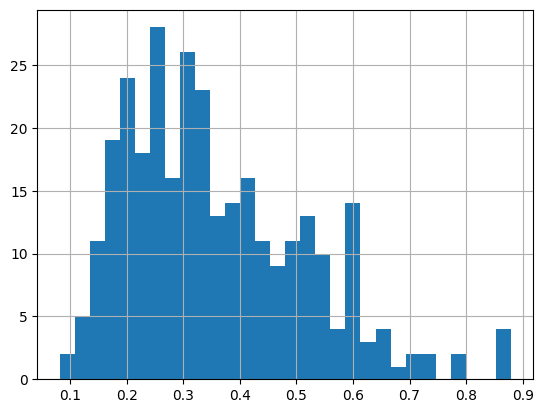

In [57]:
correlation_matrix = trans_effects_df.T.corr()
np.fill_diagonal(correlation_matrix.values, 0)
correlation_matrix.max(0).hist(bins=30)

<Axes: xlabel='target_contrast_gene_name', ylabel='target_contrast_gene_name'>

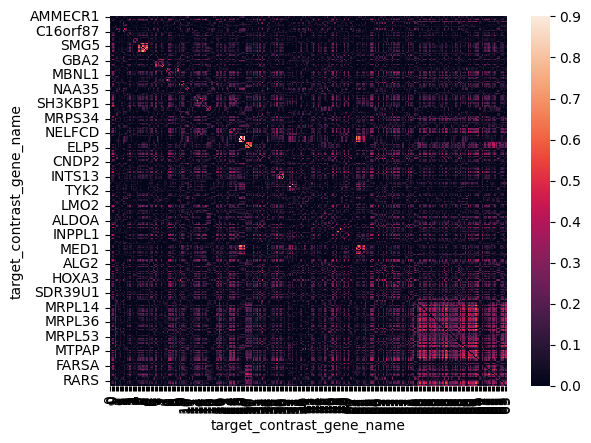

In [60]:
#fig, ax = plt.subplots(figsize=(18,15))
sns.heatmap(correlation_matrix, xticklabels=final_df.group.values, vmin=0, vmax=0.9)

In [64]:
X = trans_effects_df.values
# We compute a 2-dimensional spectral embedding for initialization.
spectral_2d_init_np = SpectralEmbedding(n_components=2, n_neighbors=7, eigen_solver='arpack', random_state=42).fit_transform(X)
spectral_2d_init = torch.tensor(spectral_2d_init_np).contiguous()
# We use the same high-level function to create the 2D embedding object.
mde_2d = pymde.preserve_neighbors(
    data=X,
    embedding_dim=2,
    n_neighbors=7,
    repulsive_fraction=5,
).embed(X=spectral_2d_init, eps=1e-07, max_iter=3000, verbose=True)

mde_2d_ni = pymde.preserve_neighbors(
    data=X,
    embedding_dim=2,
    n_neighbors=7,
    repulsive_fraction=5,
).embed(eps=1e-07, max_iter=3000, verbose=True)

Jul 21 09:43:54 AM: Fitting a centered embedding into R^2, for a graph with 305 items and 11188 edges.
Jul 21 09:43:54 AM: `embed` method parameters: eps=1.0e-07, max_iter=3000, memory_size=10
Jul 21 09:43:54 AM: iteration 0000 | distortion 3.635341 | residual norm 17.2656 | step length 0.00443539 | percent change 12.6748
Jul 21 09:43:55 AM: iteration 0300 | distortion 0.221181 | residual norm 2.05595e-05 | step length 1 | percent change 0.0337705
Jul 21 09:43:55 AM: iteration 0600 | distortion 0.221083 | residual norm 1.11761e-06 | step length 0 | percent change 0
Jul 21 09:43:56 AM: iteration 0900 | distortion 0.221083 | residual norm 1.46993e-07 | step length 550.5 | percent change 0.000154779
Jul 21 09:43:58 AM: Converged in 1170 iterations, with residual norm 9.92673e-08
Jul 21 09:43:58 AM: Finished fitting in 3.575 seconds and 1170 iterations.
Jul 21 09:43:58 AM: average distortion 0.221 | residual norm 9.9e-08
Jul 21 09:43:58 AM: Fitting a centered embedding into R^2, for a grap

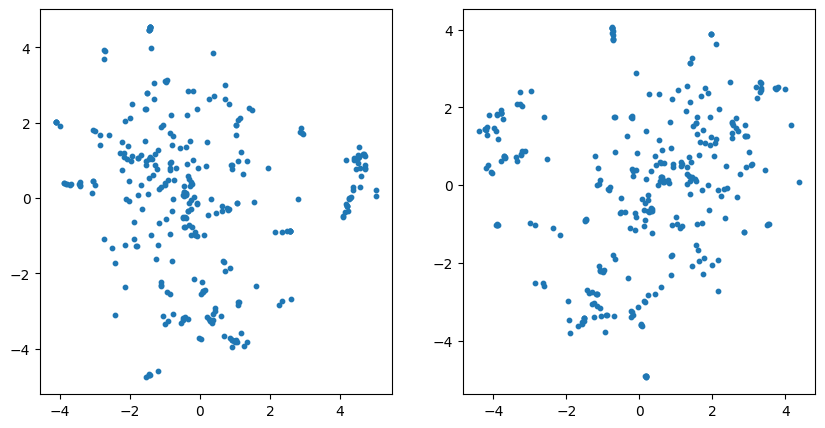

In [65]:
# Retrieve the embedding from the MDE object and convert to NumPy
embedding_np = mde_2d.numpy()
embedding_np_ni = mde_2d_ni.numpy()
fig, ax = plt.subplots(1,2,figsize=(10,5))

# Create the scatter plot
ax[0].scatter(embedding_np[:, 0], embedding_np[:, 1], s=10)
ax[1].scatter(embedding_np_ni[:, 0], embedding_np_ni[:, 1], s=10)

plt.show()

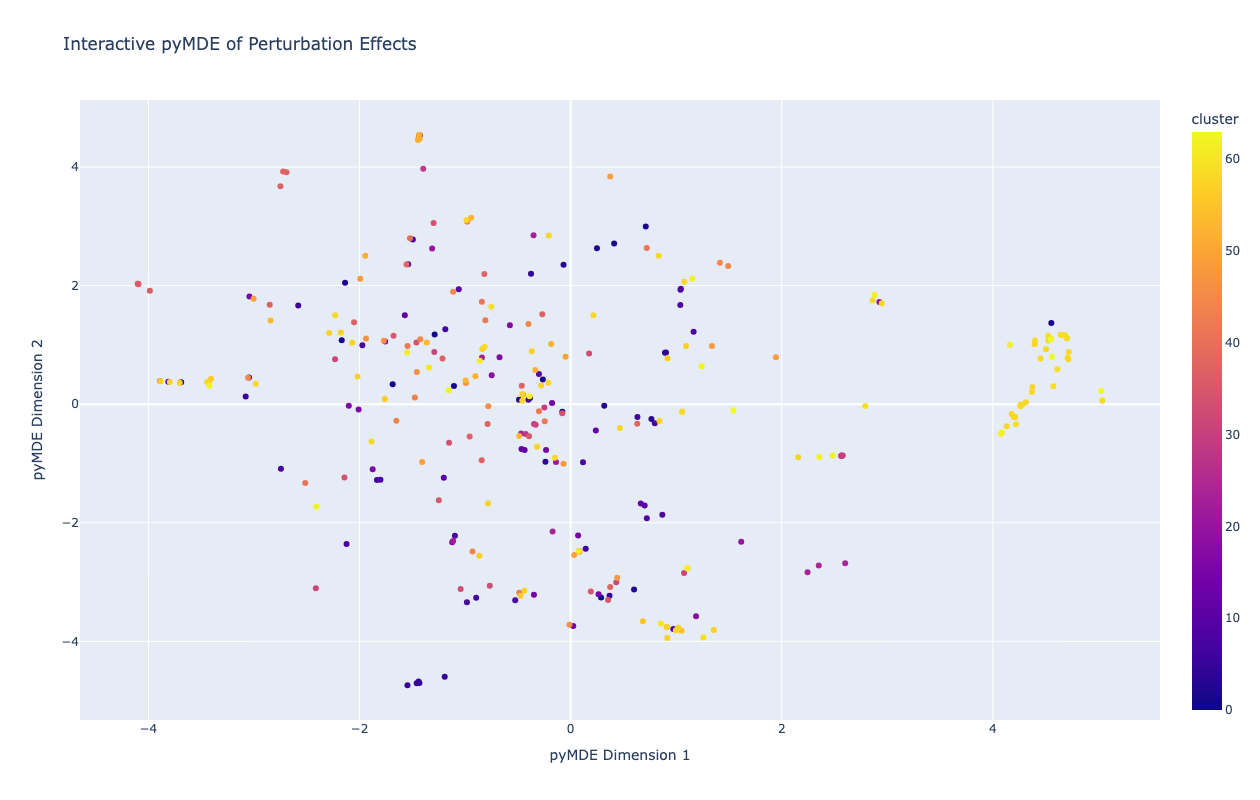

In [67]:
pymde_df = pd.DataFrame(data=embedding_np,
                        columns=['pyMDE_1', 'pyMDE_2'],
                        index=trans_effects_df.index)
pymde_df = pymde_df.loc[final_df.index]
pymde_df['cluster'] = final_df.group.values

# 4. Visualize with Plotly Express for interactivity ✨
fig = px.scatter(
    pymde_df,
    x='pyMDE_1',
    y='pyMDE_2',
    color='cluster',
    hover_name=pymde_df.index, 
    title='Interactive pyMDE of Perturbation Effects',
    width=800,
    height=800
)

# Update layout for a cleaner look
fig.update_layout(
    xaxis_title="pyMDE Dimension 1",
    yaxis_title="pyMDE Dimension 2"
)

# Show the interactive plot
fig.show()

## Try pseudobulk measurement

In [78]:
adata_pb = sc.read_h5ad('/Users/rzhu/Gladstone Dropbox/Ronghui Zhu/GRNPerturbSeq/3_expts/processed_data/CD4iR1_Psomagen/CD4iR1_Psomagen_merged.DE_pseudobulk.h5ad')

In [91]:
adata_pb

AnnData object with n_obs × n_vars = 32732 × 18117
    obs: '10xrun_id', 'cell_sample_id', 'donor_id', 'culture_condition', 'guide_id', 'perturbed_gene_name', 'perturbed_gene_id', 'guide_type', 'n_cells', 'total_counts', 'keep_min_cells', 'keep_effective_guides', 'keep_total_counts', 'keep_for_DE', 'keep_test_genes', 'log10_n_cells'
    var: 'gene_ids', 'gene_name'

In [ ]:
mask = (adata_pb.obs.culture_condition=='Rest') & (adata_pb.obs.keep_for_DE==True)
adata_pb = adata_pb[mask].copy()
pb = sc.get.aggregate(adata_pb, by='perturbed_gene_name', func='sum')
pb.X = pb.layers['sum']
sc.pp.normalize_total(pb, target_sum=1e6)
sc.pp.scale(pb)

In [112]:
pb_subset = pb[:,pb.var.gene_name.isin(var_to_choose)].copy()

In [109]:
df_list_of_genes = gene_obs_df.reset_index().rename(columns={'index': 'group'})
df_list_of_genes['genes'] = df_list_of_genes['members'].apply(lambda x: [gene.strip() for gene in x.split(',')])
long_format_df = df_list_of_genes.explode('genes')
final_df = long_format_df[['group', 'genes']].rename(columns={'genes': 'gene'})
genes_to_keep = [gene for gene in final_df.gene if gene in pb.obs.perturbed_gene_name.values]
final_df = final_df[final_df.gene.isin(genes_to_keep)]
final_df = final_df.drop_duplicates()
final_df.set_index('gene', inplace=True)

In [117]:
trans_effects_df = pd.DataFrame(data=pb_subset.X,
                                columns=pb_subset.var.gene_name,
                                index=pb_subset.obs.perturbed_gene_name)
trans_effects_df = trans_effects_df.loc[final_df.index.values]

<Axes: >

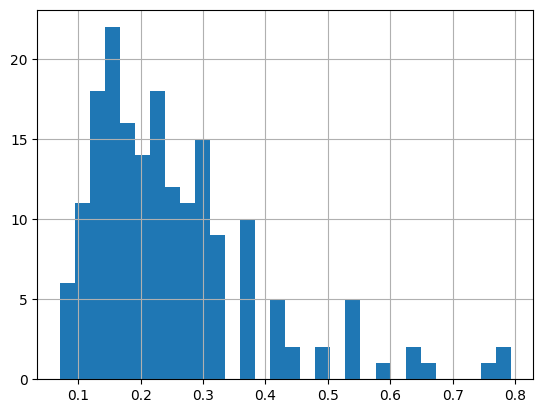

In [118]:
correlation_matrix = trans_effects_df.T.corr()
np.fill_diagonal(correlation_matrix.values, 0)
correlation_matrix.max(0).hist(bins=30)

<Axes: xlabel='perturbed_gene_name', ylabel='perturbed_gene_name'>

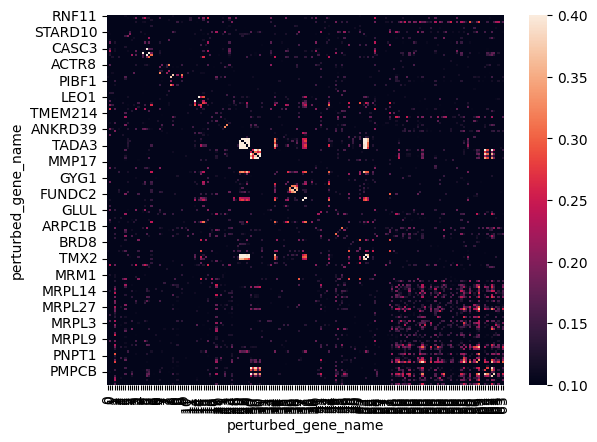

In [122]:
#fig, ax = plt.subplots(figsize=(18,15))
sns.heatmap(correlation_matrix, xticklabels=final_df.group.values, vmin=0.1, vmax=0.4)

In [89]:
adata_pb.X

array([[1.40979842e+03, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.11635621e+02],
       [1.36938485e+03, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 8.18945842e+01],
       [6.65189787e+02, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 8.61183206e+01],
       ...,
       [8.17305052e+02, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 7.79666003e+01],
       [9.65938341e+02, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 2.65221950e-01, 6.65707094e+01],
       [1.05912646e+03, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 7.77340524e+01]],
      shape=(32732, 18117))

In [90]:
np.sum(adata_pb.X, axis=1)

array([1000000., 1000000., 1000000., ..., 1000000., 1000000., 1000000.],
      shape=(32732,))

## Custom distance measurement

In [633]:
def calculate_custom_distance(col1: pd.Series, col2: pd.Series) -> float:
    is_certain1 = (col1 != 0) & (~col1.isna())
    is_certain2 = (col2 != 0) & (~col2.isna())
    both_certain_mask = is_certain1 & is_certain2
    filtered_col1 = col1[both_certain_mask]
    filtered_col2 = col2[both_certain_mask]
    num_certain_pairs = len(filtered_col1)
    if num_certain_pairs == 0:
        return np.nan
    squared_errors = (filtered_col1 - filtered_col2) ** 2
    mean_squared_error = squared_errors.sum() / num_certain_pairs
    distance = np.sqrt(mean_squared_error)

    return distance

In [657]:
genes = None
cond = 'Rest'
effect_stat = 'zscore'
signif_stat = 'adj_p_value'
signif_alpha = 0.2

trans_effects_df = pd.DataFrame()
gene_added = []
group_added = []

for i in groups_to_choose:
    res_df = get_DE_results_long(
    adata_de, 
    targets=final_df.loc[final_df.group==i, 'gene'].values, genes=genes,
    effect_estimates=[effect_stat], signif_alpha=signif_alpha, signif_estimate=signif_stat)
    res_df = res_df[res_df['culture_condition'] == cond]
    res_df.loc[res_df['target_contrast_gene_name'] == res_df['gene'], effect_stat] = 0
    res_df = res_df[res_df['significant']]
    temp = res_df.pivot(columns=['culture_condition','target_contrast_gene_name'], index='gene', values=effect_stat)
    temp.columns = [f"{target}" for cond, target in temp.columns]
    #trans_effects_df = np.sign(trans_effects_df).fillna(0)
    temp = temp.fillna(0)
    trans_effects_df = pd.concat([trans_effects_df, temp], axis=1)
    if len(temp.columns)!=0:
        gene_added = gene_added + temp.columns.tolist()
        group_added = group_added + ([i]*len(temp.columns))
    
#trans_effects_df = np.sign(trans_effects_df).fillna(0)
trans_effects_df = trans_effects_df.fillna(0)
group_info = pd.DataFrame({'gene':gene_added, 'group':group_added})
group_info = group_info.loc[~trans_effects_df.columns.duplicated()]
trans_effects_df = trans_effects_df.loc[:, ~trans_effects_df.columns.duplicated()]

distance_matrix = pd.DataFrame(index=trans_effects_df.columns, columns=trans_effects_df.columns, dtype=float)

#for i in range(len(trans_effects_df.columns)):
#    for j in range(i, len(trans_effects_df.columns)):
#        col_i_name = trans_effects_df.columns[i]
#        col_j_name = trans_effects_df.columns[j]

#        if i == j:
#            # The distance from a column to itself is 0
#            dist = 0.0
#        else:
#            dist = calculate_custom_distance(trans_effects_df[col_i_name], trans_effects_df[col_j_name])
#        distance_matrix.loc[col_i_name, col_j_name] = dist
#        distance_matrix.loc[col_j_name, col_i_name] = dist # Matrix is symmetric
#distance_matrix = distance_matrix.fillna(np.max(distance_matrix))
#embedding = pymde.preserve_distances(
#    distance_matrix.values
#).embed()

In [658]:
correlation_matrix = trans_effects_df.corr()
np.fill_diagonal(correlation_matrix.values, 0)

<Axes: >

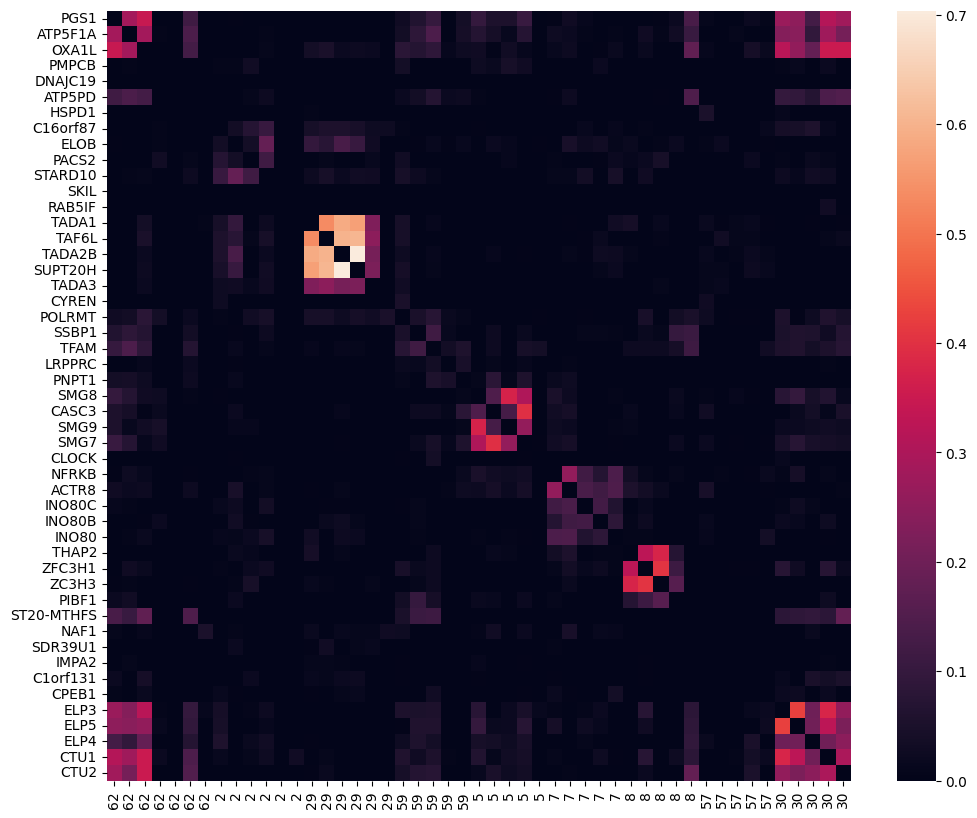

In [659]:
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(correlation_matrix, xticklabels=group_info.group, yticklabels=True, vmin=0)

In [660]:
embedding = pymde.preserve_distances(
    correlation_matrix.values
).embed()

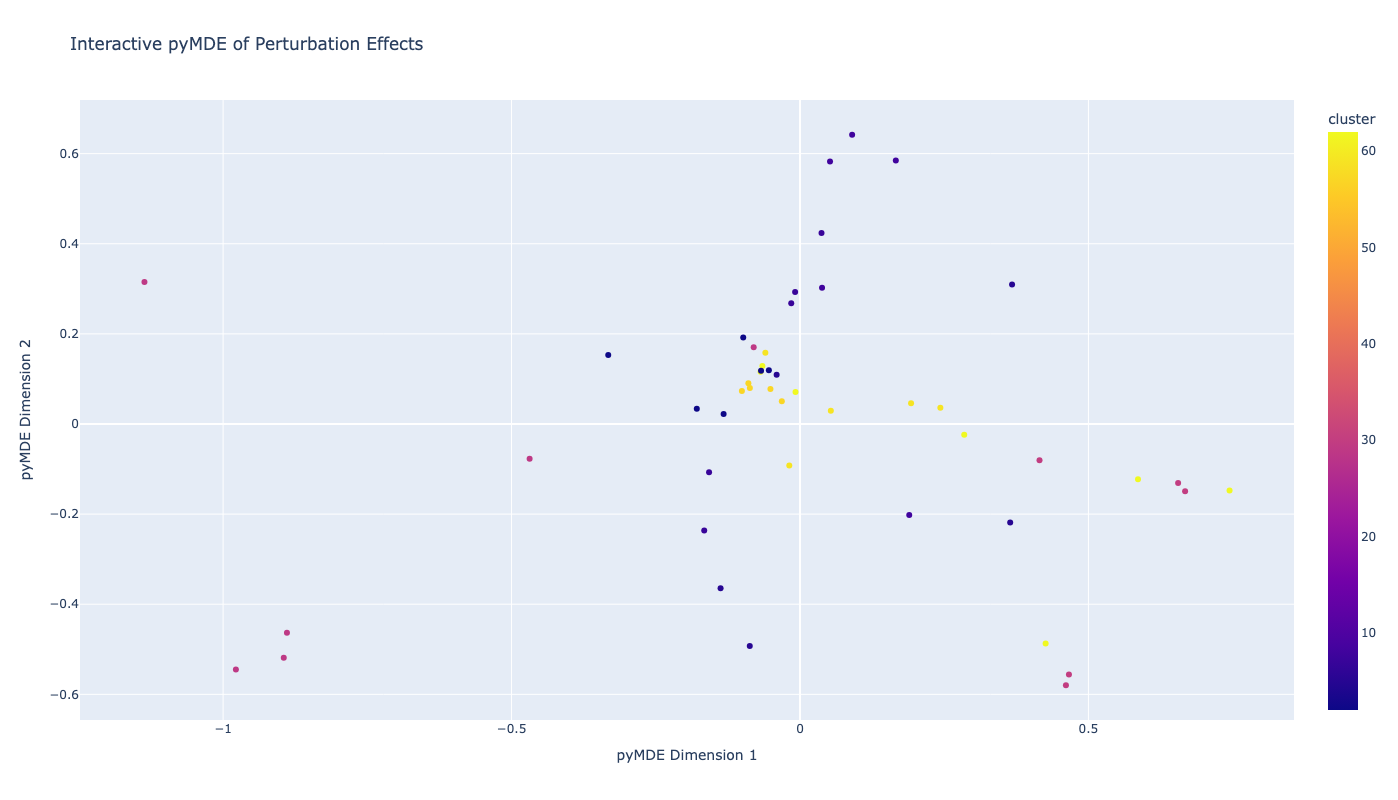

In [661]:
pymde_df = pd.DataFrame(data=embedding,
                        columns=['pyMDE_1', 'pyMDE_2'],
                        index=correlation_matrix.index)

pymde_df['cluster'] = group_info.group.values

# 4. Visualize with Plotly Express for interactivity ✨
fig = px.scatter(
    pymde_df,
    x='pyMDE_1',
    y='pyMDE_2',
    color='cluster',
    hover_name=pymde_df.index, 
    title='Interactive pyMDE of Perturbation Effects',
    width=800,
    height=800
)

# Update layout for a cleaner look
fig.update_layout(
    xaxis_title="pyMDE Dimension 1",
    yaxis_title="pyMDE Dimension 2"
)

# Show the interactive plot
fig.show()

<Axes: >

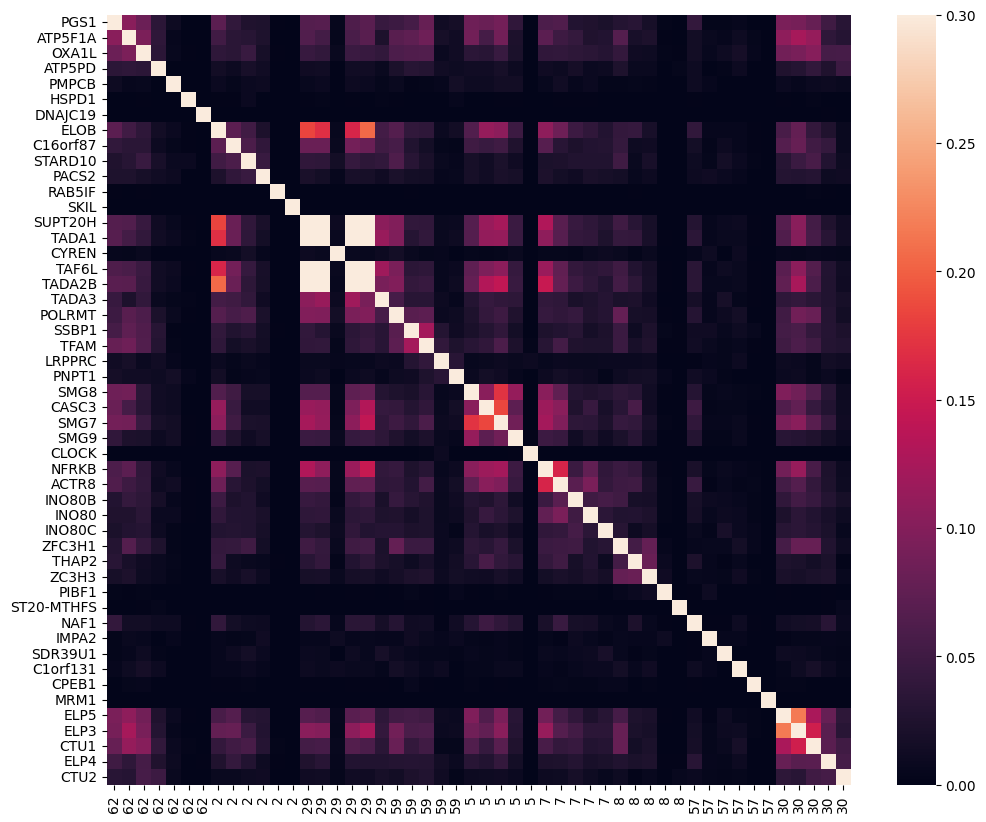

In [604]:
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(similarity, xticklabels=group_info.group, yticklabels=True, vmin=0, vmax=0.3)

## Shared effects between perturbations

In [416]:
# Restict to perturbations with at least 2 significant DE genes
targets = de_counts[(de_counts.condition == 'Rest') & (de_counts.n_total_de_genes > 10)].target_name.tolist()
genes = None
cond = 'Rest'
effect_stat = 'zscore'
signif_stat = 'adj_p_value'
signif_alpha = 0.05

res_df = get_DE_results_long(
    adata_de, 
    targets=targets, genes=genes,
    effect_estimates=[effect_stat], signif_alpha=signif_alpha, signif_estimate=signif_stat)
res_df = res_df[res_df['culture_condition'] == cond]

res_df.loc[res_df['target_contrast_gene_name'] == res_df['gene'], effect_stat] = 0
res_df = res_df[res_df['significant']]

In [417]:
trans_effects_df = res_df.pivot(columns=['culture_condition','target_contrast_gene_name'], index='gene', values=effect_stat)
trans_effects_df.columns = [f"{cond}_{target}" for cond, target in trans_effects_df.columns]
trans_effects_df_sign = np.sign(trans_effects_df).fillna(0)
#trans_effects_df = np.sign(trans_effects_df).fillna(0)
trans_effects_df = trans_effects_df.fillna(0)
#trans_effects_df = trans_effects_df.loc[:, np.abs(trans_effects_df).sum(0) > 1]
#trans_effects_df = trans_effects_df[trans_effects_df.sum(1) != 0]
trans_effects_df

Rest_TP53  Rest_FUBP1  Rest_ARF1  Rest_SIN3B  Rest_FANCF  \
gene                                                                        
ENSG00000000419   3.133527    -4.34739    2.92918    6.481054   -3.817773   
ENSG00000000460   0.000000     0.00000    0.00000    0.000000    0.000000   
ENSG00000000971   0.000000     0.00000    0.00000    0.000000    0.000000   
ENSG00000001036   0.000000     0.00000    0.00000    0.000000    0.000000   
ENSG00000001084   0.000000     0.00000    0.00000    0.000000    0.000000   
...                    ...         ...        ...         ...         ...   
ENSG00000284770   0.000000     0.00000    0.00000    0.000000    0.000000   
ENSG00000285077   0.000000     0.00000    0.00000    0.000000    0.000000   
ENSG00000290292  -2.664171     0.00000    0.00000    0.000000    0.000000   
ENSG00000290797   0.000000     0.00000    0.00000    0.000000    0.000000   
ENSG00000291237   0.000000     0.00000    0.00000    0.000000    0.000000   

                 Rest_CALHM6  Rest_RNF20  Rest_CCDC6  Rest_CD9  Rest_TP53BP1  \
gene                                                                           
ENSG00000000419     -4.84045    3.702069   -3.261736  0.000000      0.000000   
ENSG00000000460      0.00000    0.000000    0.000000  3.504768     -3.708275   
ENSG00000000971      0.00000    0.000000    0.000000  0.000000      0.000000   
ENSG00000001036      0.00000    0.000000    0.000000  0.000000      0.000000   
ENSG00000001084      0.00000    0.000000    0.000000  0.000000      0.000000   
...                      ...         ...         ...       ...           ...   
ENSG00000284770      0.00000    0.000000    0.000000  0.000000      0.000000   
ENSG00000285077      0.00000    0.000000    0.000000  3.834162      0.000000   
ENSG00000290292      0.00000    0.000000    4.978310  0.000000      0.000000   
ENSG00000290797      0.00000    0.000000    0.000000  0.000000      0.000000   
ENSG00000291237      0.00000    0.000000    0.000000  0.000000      0.000000   

                 ...  Rest_TEAD4  Rest_PDP1  Rest_ARL10  Rest_ACTR2  \
gene             ...                                                  
ENSG00000000419  ...         0.0        0.0         0.0         0.0   
ENSG00000000460  ...         0.0        0.0         0.0         0.0   
ENSG00000000971  ...         0.0        0.0         0.0         0.0   
ENSG00000001036  ...         0.0        0.0         0.0         0.0   
ENSG00000001084  ...         0.0        0.0         0.0         0.0   
...              ...         ...        ...         ...         ...   
ENSG00000284770  ...         0.0        0.0         0.0         0.0   
ENSG00000285077  ...         0.0        0.0         0.0         0.0   
ENSG00000290292  ...         0.0        0.0         0.0         0.0   
ENSG00000290797  ...         0.0        0.0         0.0         0.0   
ENSG00000291237  ...         0.0        0.0         0.0         0.0   

                 Rest_MAD2L1BP  Rest_WASF2  Rest_DPM3  Rest_CD2BP2  \
gene                                                                 
ENSG00000000419            0.0         0.0        0.0          0.0   
ENSG00000000460            0.0         0.0        0.0          0.0   
ENSG00000000971            0.0         0.0        0.0          0.0   
ENSG00000001036            0.0         0.0        0.0          0.0   
ENSG00000001084            0.0         0.0        0.0          0.0   
...                        ...         ...        ...          ...   
ENSG00000284770            0.0         0.0        0.0          0.0   
ENSG00000285077            0.0         0.0        0.0          0.0   
ENSG00000290292            0.0         0.0        0.0          0.0   
ENSG00000290797            0.0         0.0        0.0          0.0   
ENSG00000291237            0.0         0.0        0.0          0.0   

                 Rest_PNPT1  Rest_BMI1  
gene                                    
ENSG00000000419         0.0        0.0  
ENSG00000000460 

In [418]:
correlation_matrix = trans_effects_df.corr()
np.fill_diagonal(correlation_matrix.values, 0)

<Axes: >

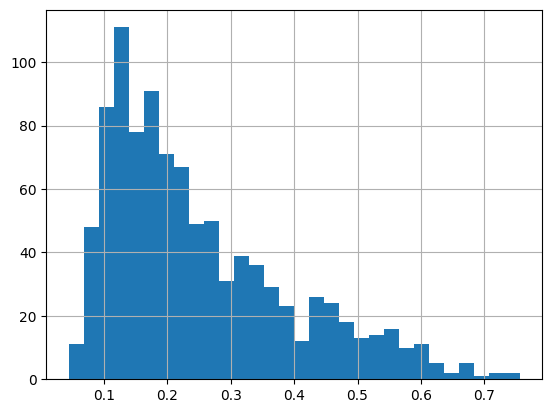

In [419]:
correlation_matrix.max(0).hist(bins=30)

In [471]:
JI_thresh = 0
keep_tests = correlation_matrix.max(0) > JI_thresh
filtered_corr_matrix = correlation_matrix.loc[keep_tests, keep_tests]

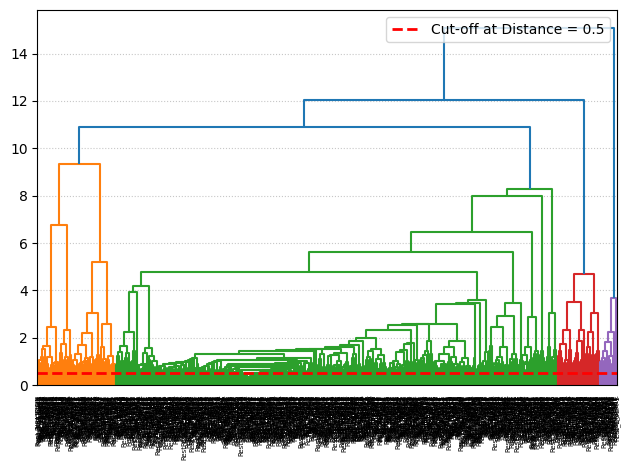

In [475]:
hierarchical = AgglomerativeClustering(n_clusters=None, distance_threshold=1.3, linkage='complete') # Set distance_threshold to 0 and n_clusters to None to get the full hierarchy
perturbation_clusters_hierarchical = hierarchical.fit_predict(filtered_corr_matrix)
linked = linkage(filtered_corr_matrix, 'ward') # 'ward' is a common linkage method
dendrogram(
    linked,
    orientation='top',
    labels=filtered_corr_matrix.index.tolist(), # Use perturbation names as labels
    distance_sort='descending',
    show_leaf_counts=True,
)
cut_off_distance = 0.5 # Example: Adjust this value after viewing the dendrogram
plt.axhline(y=cut_off_distance, color='r', linestyle='--', linewidth=2, label=f'Cut-off at Distance = {cut_off_distance}')
plt.legend(fontsize=10)
plt.grid(axis='y', linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

In [486]:
data_for_pymde = trans_effects_df.loc[:,keep_tests].T
embedding = pymde.preserve_neighbors(data_for_pymde.values,
                                     attractive_penalty=pymde.penalties.Log1p,
                                     repulsive_penalty=pymde.penalties.Log,
                                     embedding_dim=2,
                                     n_neighbors=4,
                                     repulsive_fraction=2).embed()

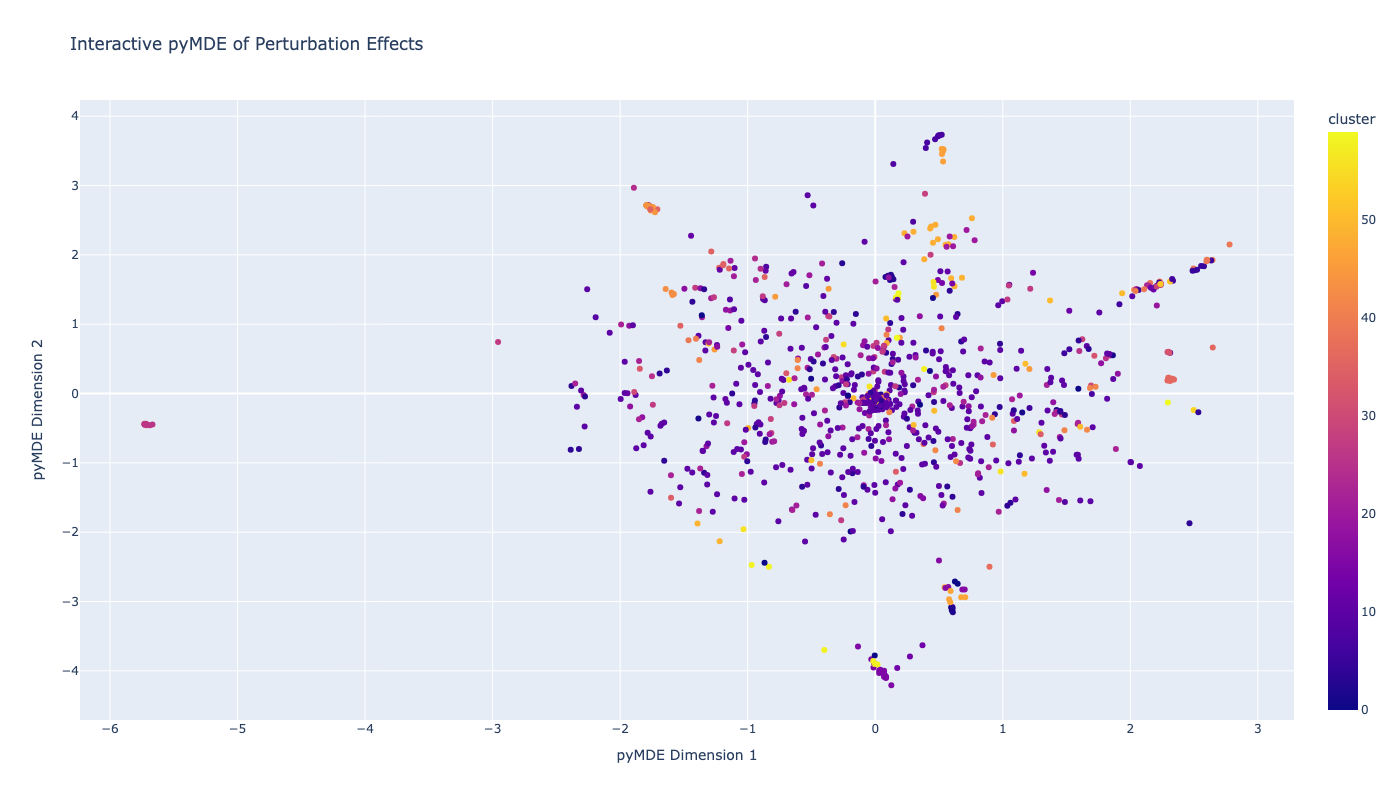

In [487]:
# 3. Visualize the results
pymde_df = pd.DataFrame(data=embedding,
                        columns=['pyMDE_1', 'pyMDE_2'],
                        index=data_for_pymde.index)
pymde_df['cluster'] = perturbation_clusters_hierarchical

# 4. Visualize with Plotly Express for interactivity ✨
fig = px.scatter(
    pymde_df,
    x='pyMDE_1',
    y='pyMDE_2',
    color='cluster',
    hover_name=pymde_df.index, 
    title='Interactive pyMDE of Perturbation Effects',
    width=800,
    height=800
)

# Update layout for a cleaner look
fig.update_layout(
    xaxis_title="pyMDE Dimension 1",
    yaxis_title="pyMDE Dimension 2"
)

# Show the interactive plot
fig.show()

In [389]:
np.concatenate([np.where(perturbation_clusters_hierarchical==21)[0], np.where(perturbation_clusters_hierarchical==25)[0]])

array([ 88, 123, 168, 220, 235, 236, 278, 288, 290, 292, 297, 215])

In [427]:
mask = np.concatenate([np.where(perturbation_clusters_hierarchical==6)[0],
                       np.where(perturbation_clusters_hierarchical==15)[0],
                       np.where(perturbation_clusters_hierarchical==9)[0],
                      np.where(perturbation_clusters_hierarchical==17)[0]])
test = filtered_data.iloc[mask, mask]

<Axes: >

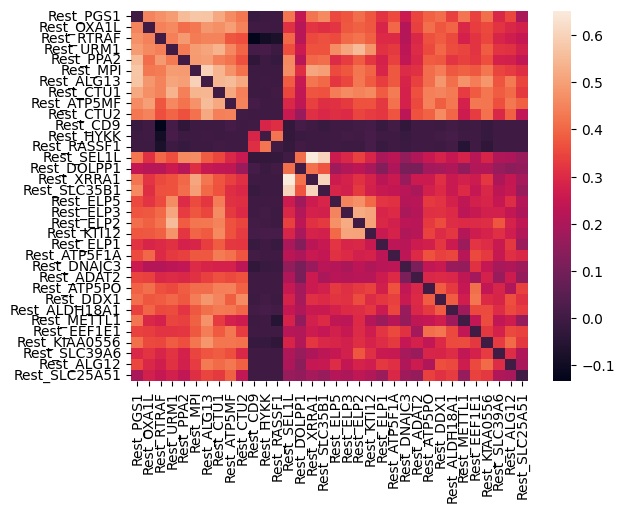

In [428]:
sns.heatmap(test, xticklabels=True, yticklabels=True,)

/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.

/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



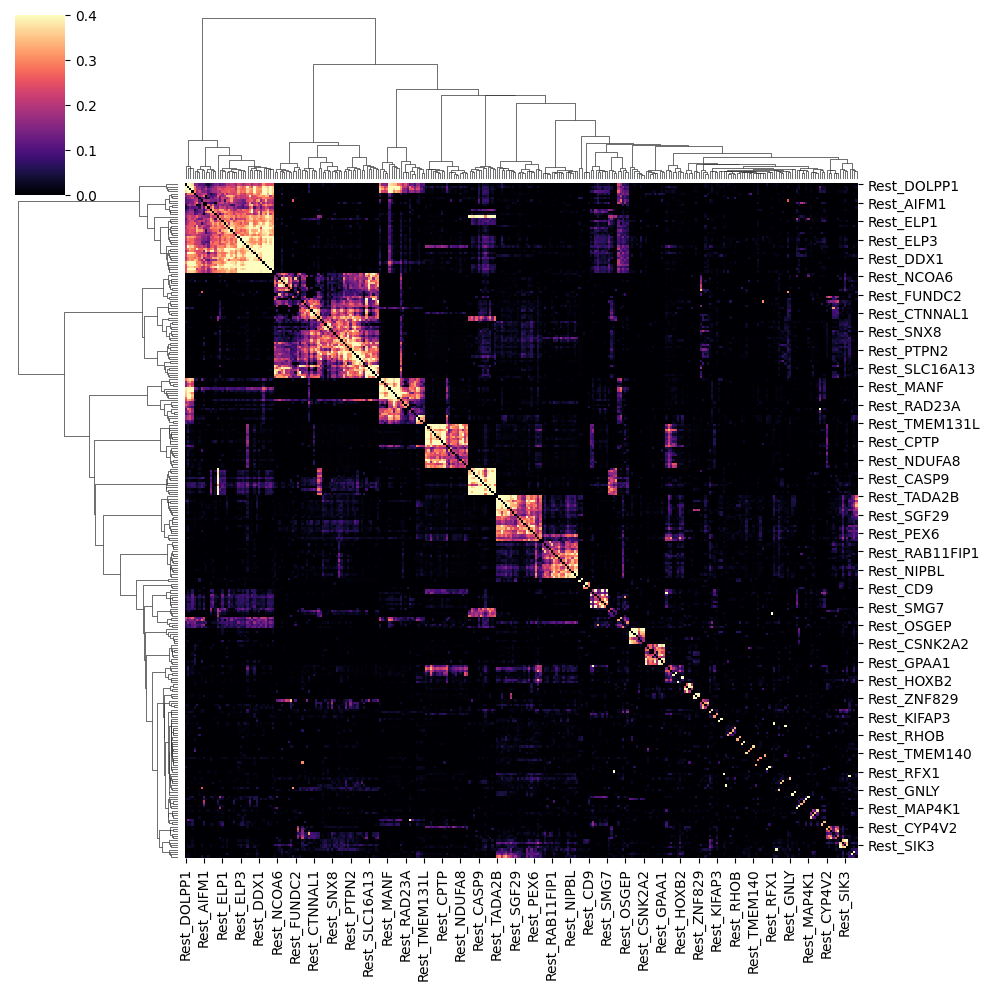

In [426]:
# Filter by fraction of shared effects and keep top JI pairs
JI_thresh = 0.3

#plt.figure(figsize=(4,4))
#filtered_data = similarity.copy()
#filtered_data[shared_effects < 3] = 0
#np.fill_diagonal(filtered_data.values, 0)
#filtered_data.max(0).sort_values().hist(bins=30)
#plt.axvline(JI_thresh, color='black')
filtered_data = correlation_matrix

keep_tests = filtered_data.max(0) > JI_thresh
filtered_data = filtered_data.loc[keep_tests, keep_tests]
order_perts = filtered_data.sum(0).sort_values(ascending=False).index.tolist()
ordered_data = filtered_data.loc[order_perts, order_perts]

# First generate clustermap to get ordering
clustermap = sns.clustermap(
    ordered_data,
    method='ward', metric='euclidean',
    figsize=(10,10), 
    cmap='magma',
    vmax=0.4,
    vmin=0
)

# Get the row and column ordering from the clustermap
row_order = clustermap.dendrogram_row.reordered_ind
col_order = clustermap.dendrogram_col.reordered_ind
reordered_data = ordered_data.iloc[row_order, col_order]

# Compute Jaccard similarity between perturbations 

In [193]:
# Compute intersection
pos_trans_effects_df = trans_effects_df.copy()
pos_trans_effects_df[pos_trans_effects_df < 0] = 0
neg_trans_effects_df = trans_effects_df.copy()
neg_trans_effects_df[neg_trans_effects_df > 0] = 0
shared_effects = pos_trans_effects_df.T.dot(pos_trans_effects_df) + neg_trans_effects_df.T.dot(neg_trans_effects_df)

# Compute size of union
n = shared_effects.shape[0]
total_genes = np.diag(shared_effects)
total_i = np.tile(total_genes.reshape(-1, 1), (1, n))
total_j = np.tile(total_genes.reshape(1, -1), (n, 1))
union = total_i + total_j - shared_effects

# Jaccard index (intersection / union)
similarity = np.divide(shared_effects.values, union, 
                            out=np.zeros_like(shared_effects, dtype=float), 
                            where=union!=0)

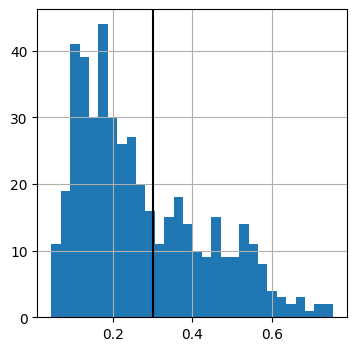

In [199]:
filtered_data = correlation_matrix
JI_thresh = 0.3
plt.figure(figsize=(4,4))
np.fill_diagonal(filtered_data.values, 0)
filtered_data.max(0).sort_values().hist(bins=30)
plt.axvline(JI_thresh, color='black')

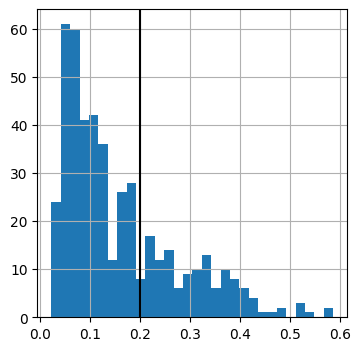

In [196]:
JI_thresh = 0.2

plt.figure(figsize=(4,4))
filtered_data = similarity.loc[shared_effects.sum(1) > 20, shared_effects.sum(1) > 20]
np.fill_diagonal(filtered_data.values, 0)
filtered_data.max(0).sort_values().hist(bins=30)
plt.axvline(JI_thresh, color='black')

/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.

/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



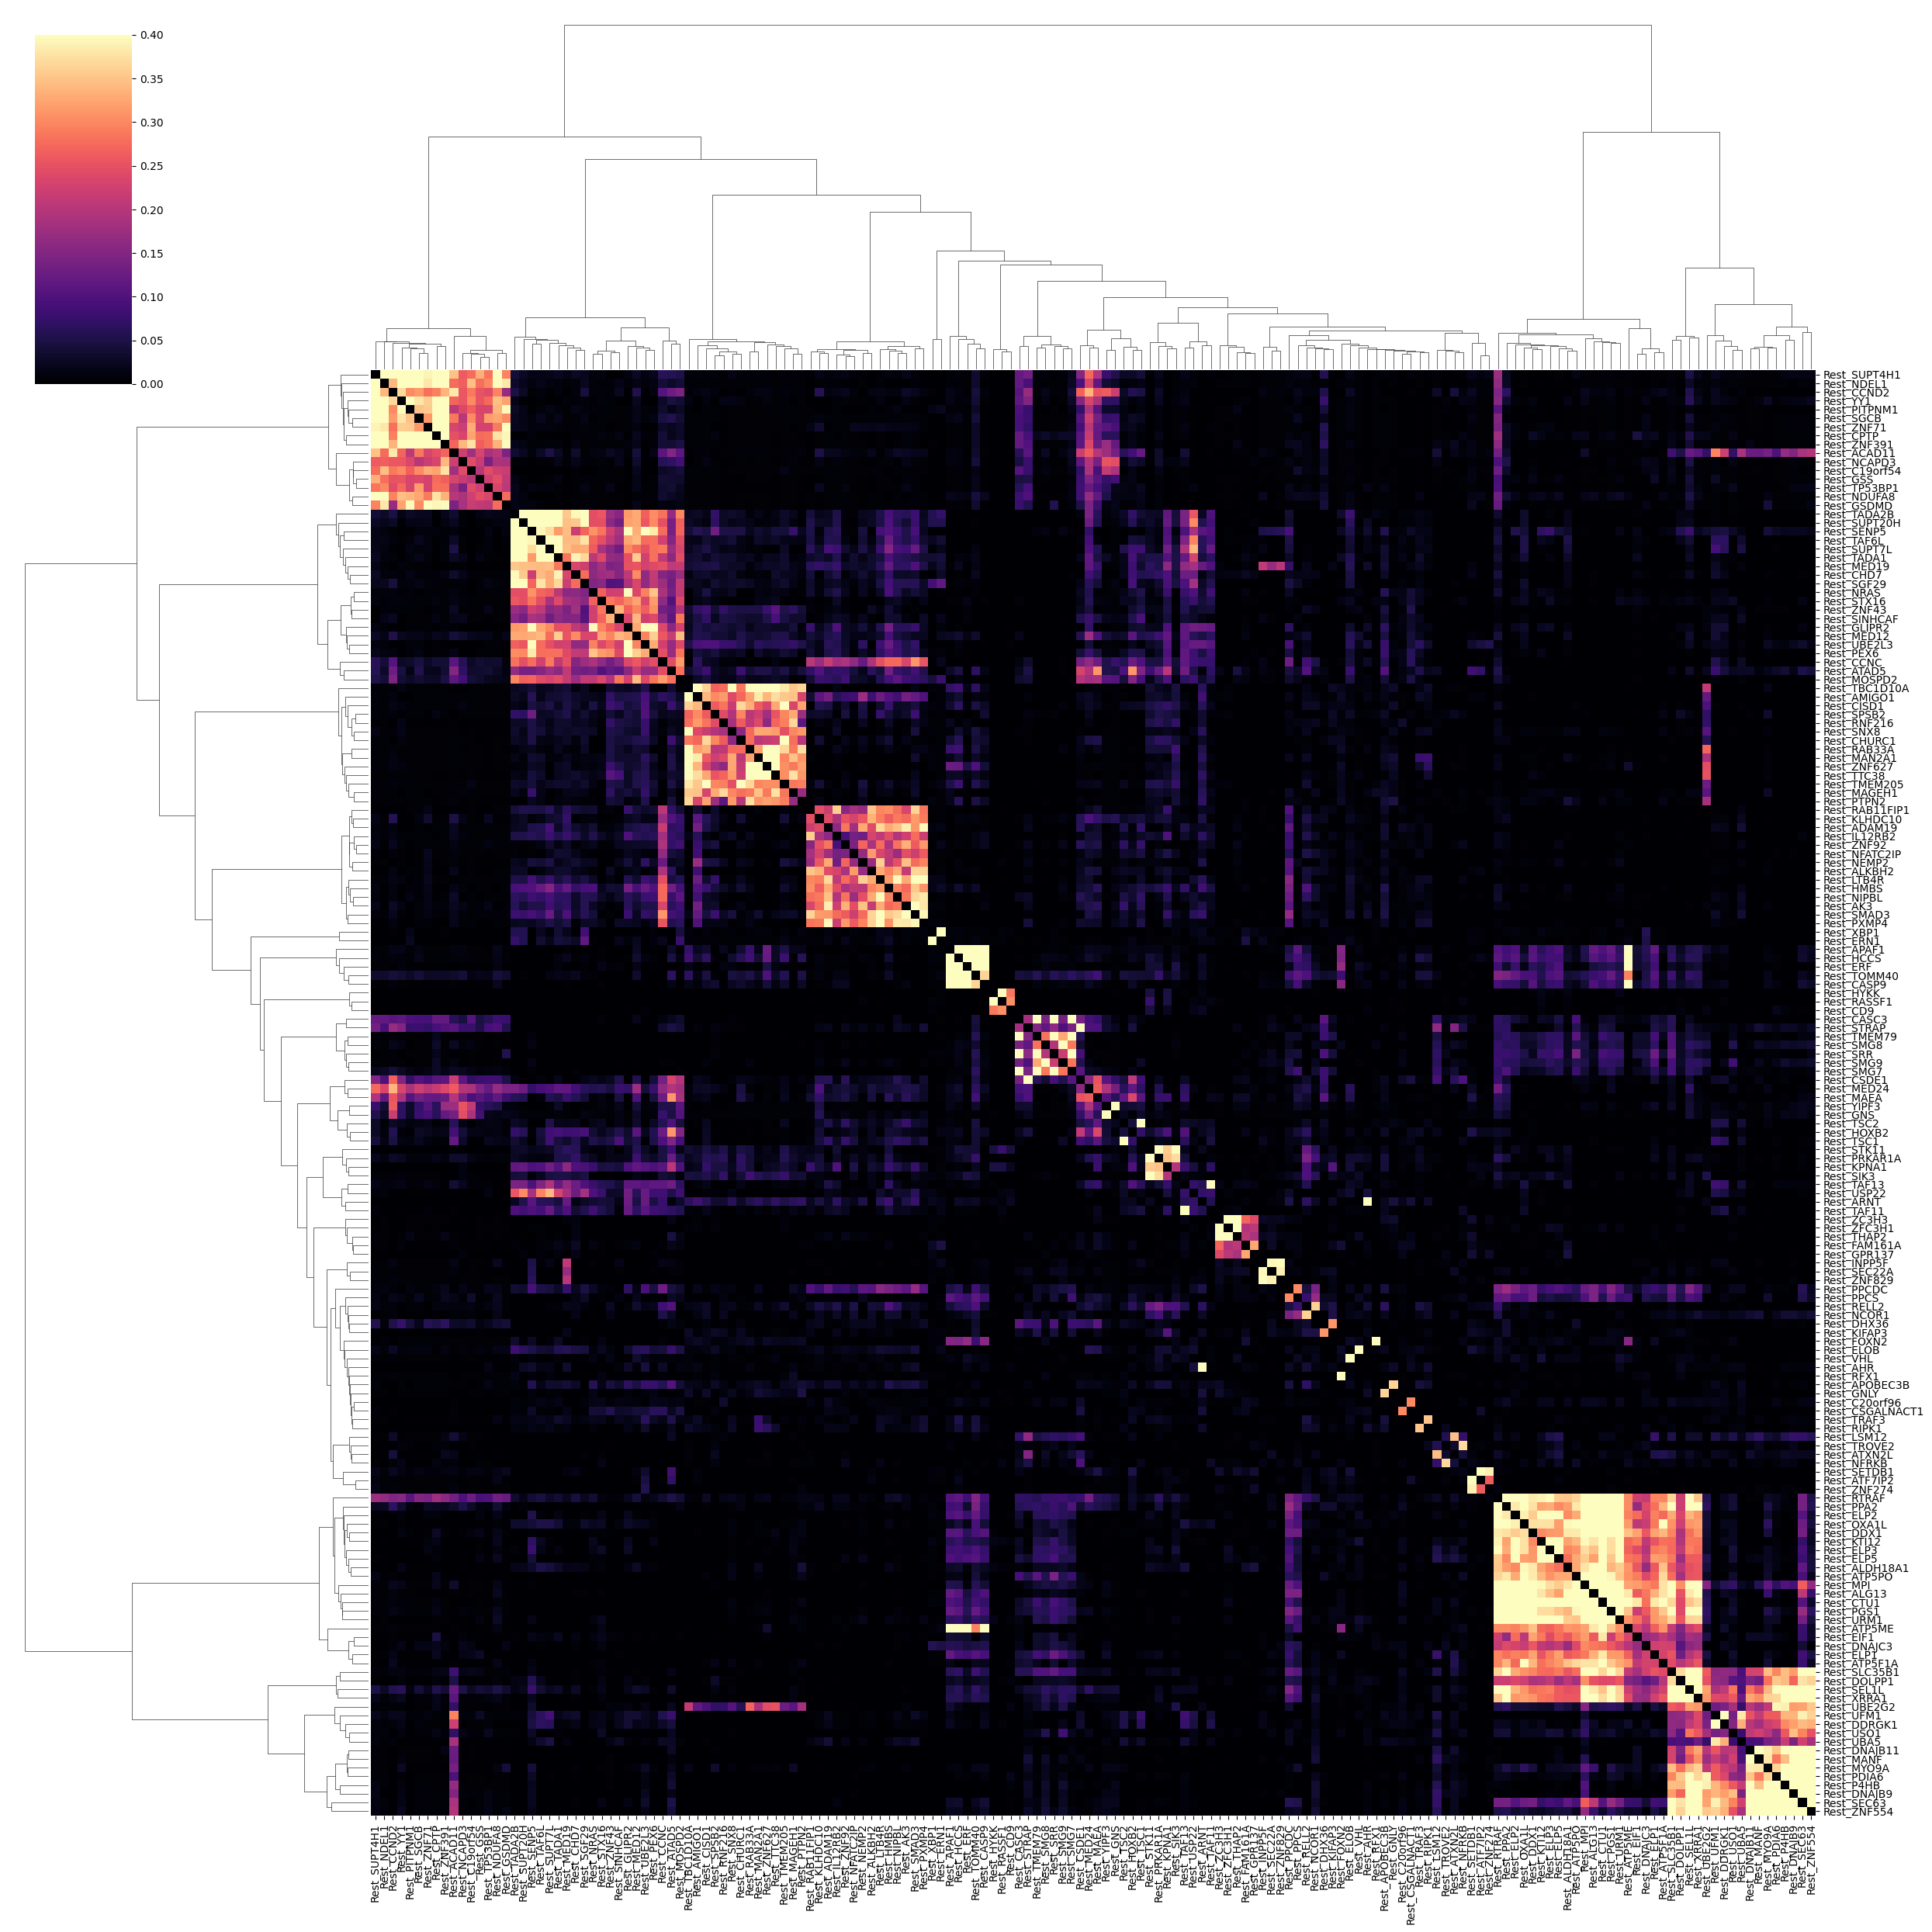

In [200]:
# Filter by fraction of shared effects and keep top JI pairs
JI_thresh = 0.3

#plt.figure(figsize=(4,4))
#filtered_data = similarity.copy()
#filtered_data[shared_effects < 3] = 0
#np.fill_diagonal(filtered_data.values, 0)
#filtered_data.max(0).sort_values().hist(bins=30)
#plt.axvline(JI_thresh, color='black')

keep_tests = filtered_data.max(0) > JI_thresh
filtered_data = filtered_data.loc[keep_tests, keep_tests]
order_perts = filtered_data.sum(0).sort_values(ascending=False).index.tolist()
ordered_data = filtered_data.loc[order_perts, order_perts]

# First generate clustermap to get ordering
clustermap = sns.clustermap(
    ordered_data,
    method='ward', metric='euclidean',
    figsize=(25,25), 
    xticklabels=True, yticklabels=True,
    cmap='magma',
    vmax=0.4,
    vmin=0
)

# Get the row and column ordering from the clustermap
row_order = clustermap.dendrogram_row.reordered_ind
col_order = clustermap.dendrogram_col.reordered_ind
reordered_data = ordered_data.iloc[row_order, col_order]

/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.

/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning:

The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix

/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.

/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning:

The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



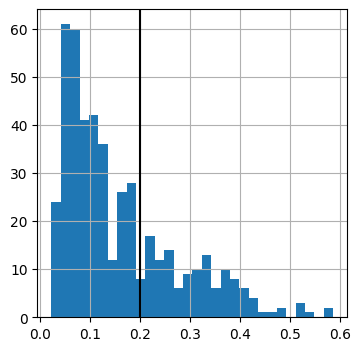

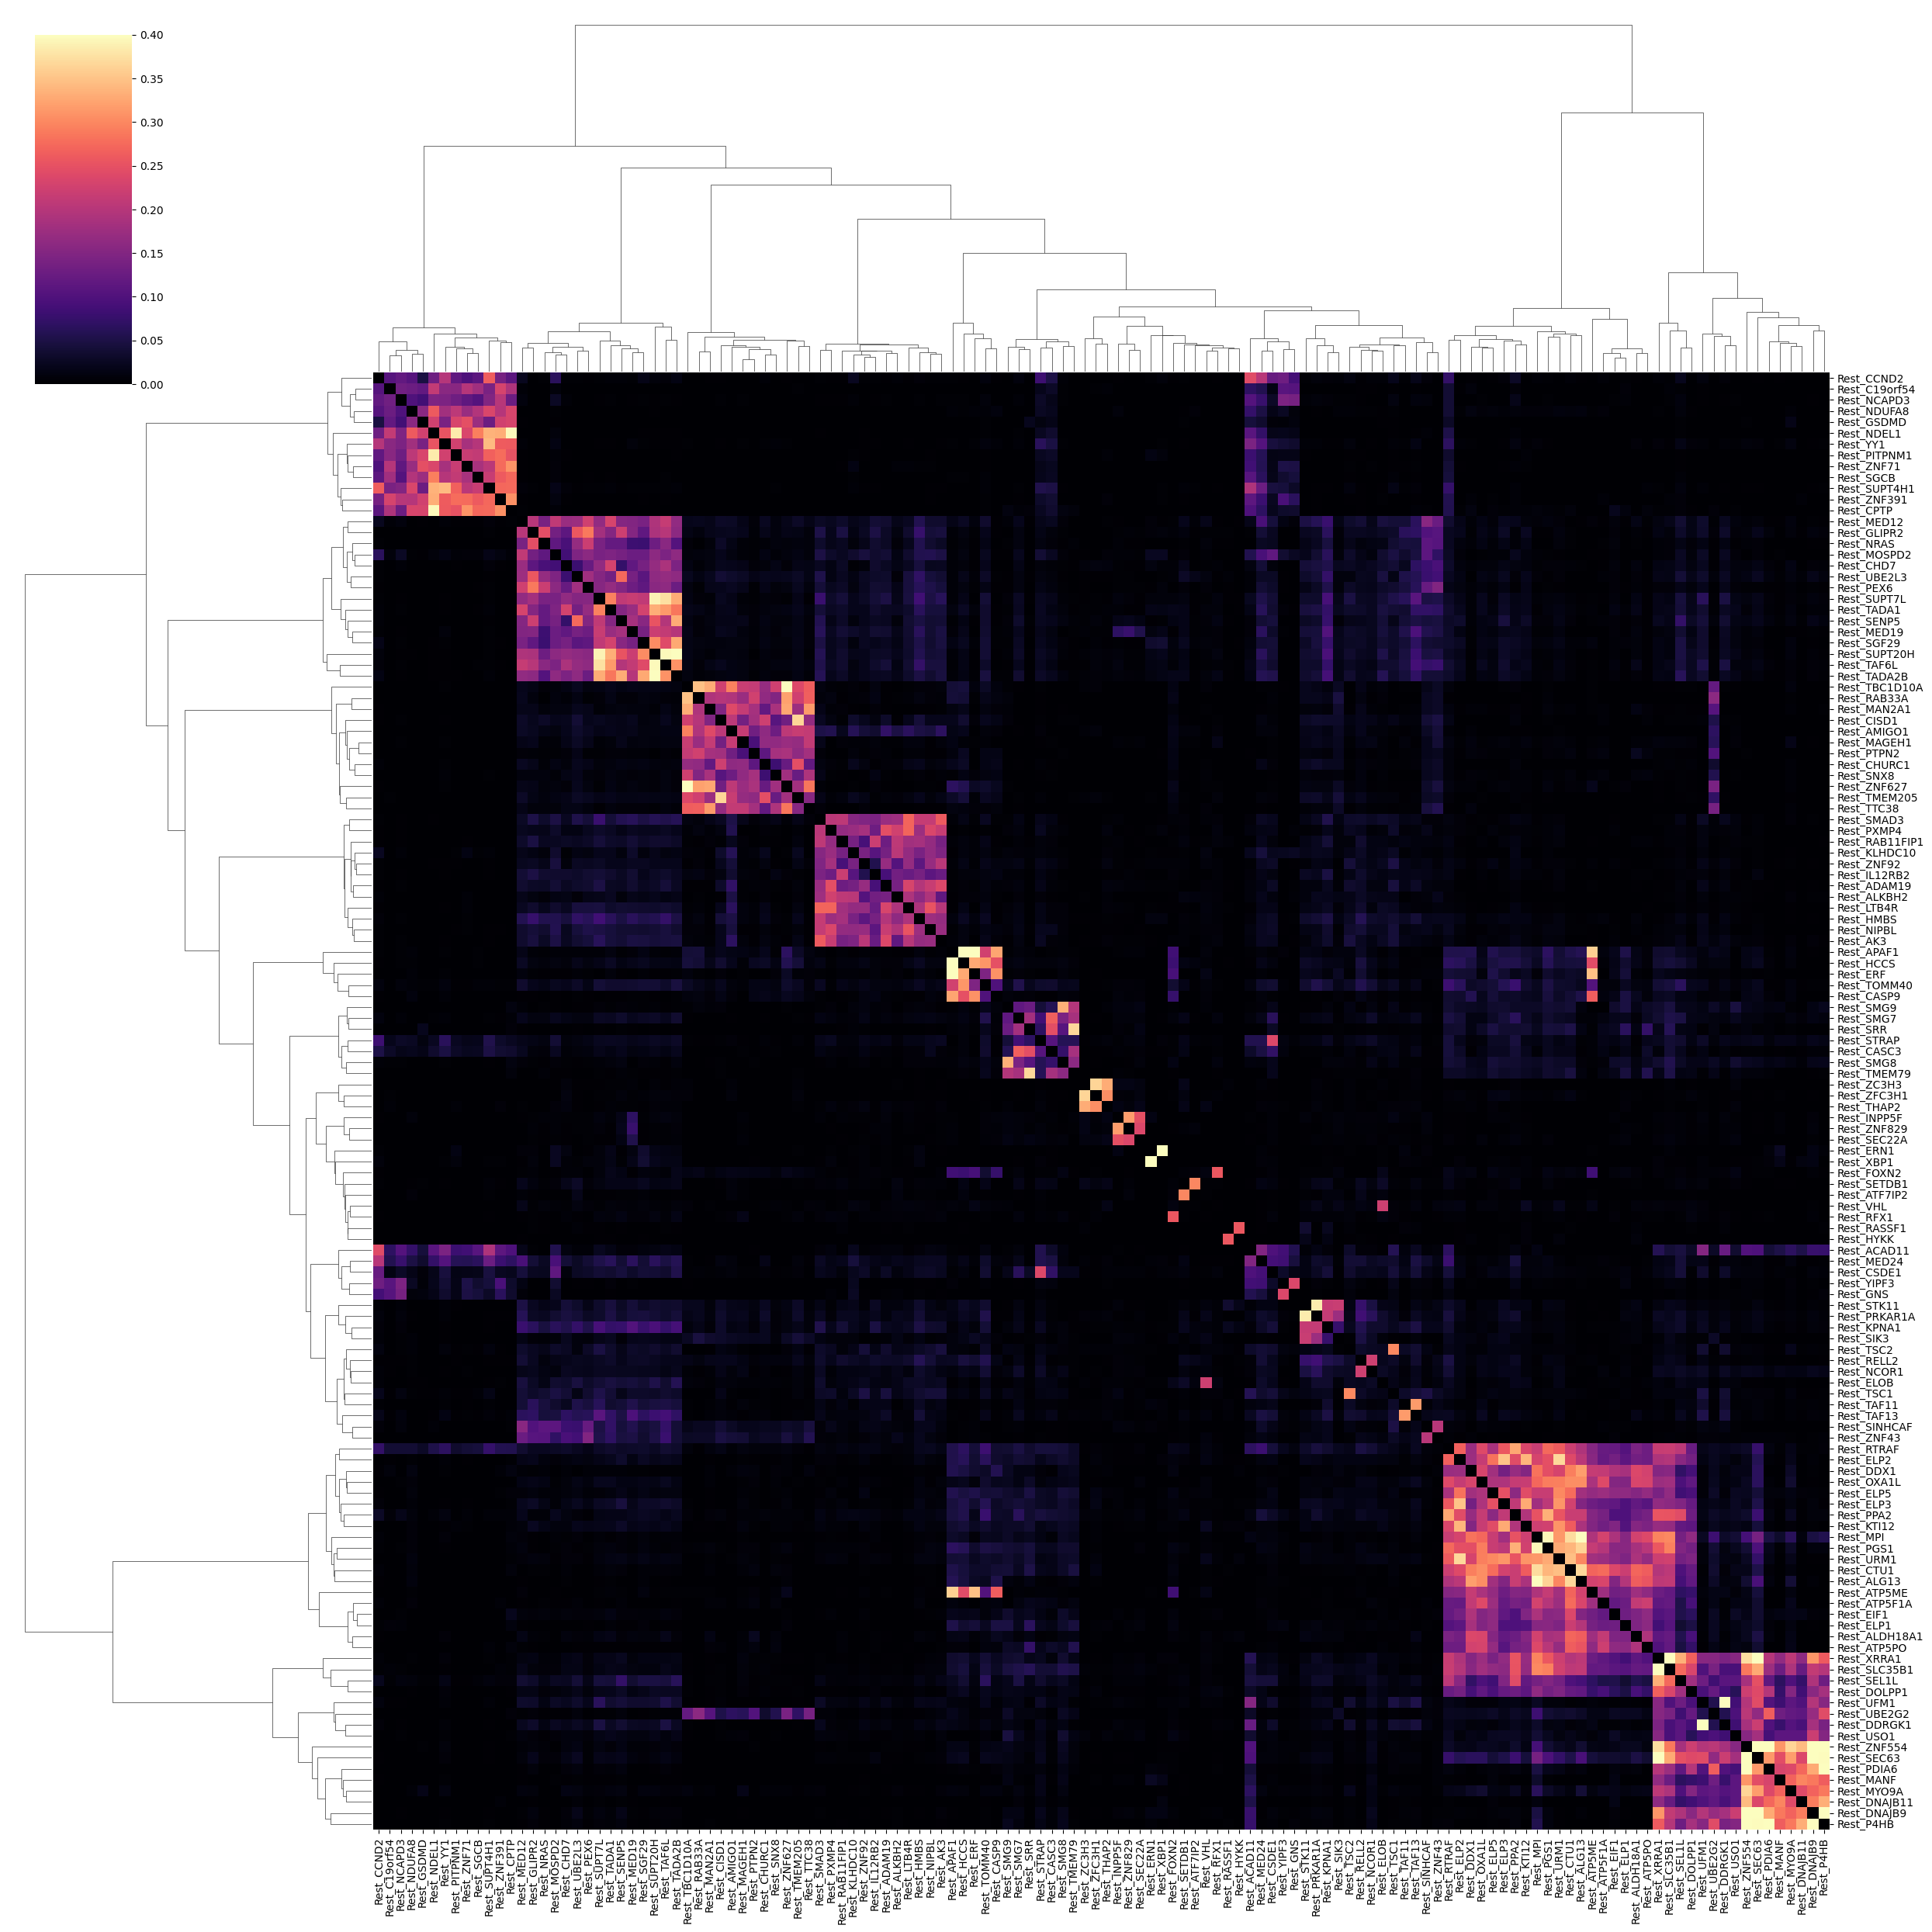

In [194]:
# Filter by fraction of shared effects and keep top JI pairs
JI_thresh = 0.2

plt.figure(figsize=(4,4))
filtered_data = similarity.copy()
filtered_data[shared_effects < 3] = 0
np.fill_diagonal(filtered_data.values, 0)
filtered_data.max(0).sort_values().hist(bins=30)
plt.axvline(JI_thresh, color='black')

keep_tests = filtered_data.max(0) > JI_thresh
filtered_data = filtered_data.loc[keep_tests, keep_tests]
order_perts = filtered_data.sum(0).sort_values(ascending=False).index.tolist()
ordered_data = filtered_data.loc[order_perts, order_perts]

# First generate clustermap to get ordering
clustermap = sns.clustermap(
    ordered_data,
    method='ward', metric='euclidean',
    figsize=(25,25), 
    xticklabels=True, yticklabels=True,
    cmap='magma',
    vmax=0.4,
    vmin=0
)

# Get the row and column ordering from the clustermap
row_order = clustermap.dendrogram_row.reordered_ind
col_order = clustermap.dendrogram_col.reordered_ind
reordered_data = ordered_data.iloc[row_order, col_order]

/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:584: ClusterWarning:

The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix

/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_37036/676505322.py:3: ClusterWarning:

The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



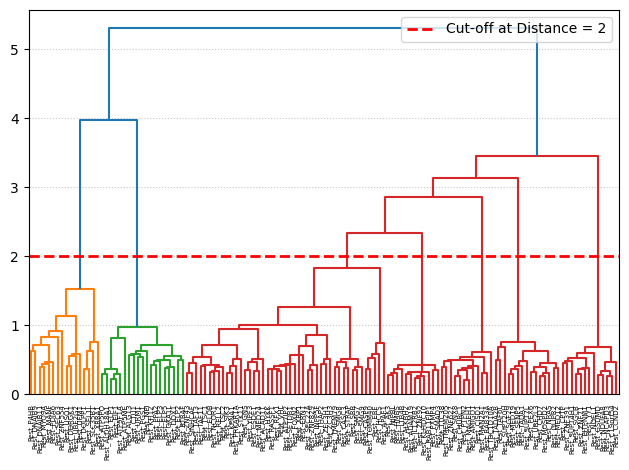

In [176]:
hierarchical = AgglomerativeClustering(n_clusters=None, distance_threshold=0, linkage='complete') # Set distance_threshold to 0 and n_clusters to None to get the full hierarchy
perturbation_clusters_hierarchical = hierarchical.fit_predict(ordered_data)
linked = linkage(ordered_data, 'ward') # 'ward' is a common linkage method
dendrogram(
    linked,
    orientation='top',
    labels=ordered_data.index.tolist(), # Use perturbation names as labels
    distance_sort='descending',
    show_leaf_counts=True,
)
cut_off_distance = 2 # Example: Adjust this value after viewing the dendrogram
plt.axhline(y=cut_off_distance, color='r', linestyle='--', linewidth=2, label=f'Cut-off at Distance = {cut_off_distance}')
plt.legend(fontsize=10)
plt.grid(axis='y', linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

In [76]:
# Compute long format for shared effects
long_shared_effects = shared_effects.reset_index().melt(
    id_vars=['index'], 
    value_name='n_shared_effects',
    var_name='target_contrast_gene_name_2'
).sort_values('n_shared_effects', ascending=False)

# Remove self-comparisons
long_shared_effects = long_shared_effects[
    long_shared_effects['index'] != long_shared_effects['target_contrast_gene_name_2']
]

# Compute long format for Jaccard index
long_jaccard_index = filtered_data.reset_index().melt(
    id_vars=['index'],
    value_name='jaccard_index', 
    var_name='target_contrast_gene_name_2'
).sort_values('jaccard_index', ascending=False)

# Remove self-comparisons
long_jaccard_index = long_jaccard_index[
    long_jaccard_index['index'] != long_jaccard_index['target_contrast_gene_name_2']
]

# Merge shared effects with Jaccard index
long_jaccard_index = long_jaccard_index.merge(
    long_shared_effects,
    on=['index', 'target_contrast_gene_name_2'],
    how='left'
)


In [ ]:
# Plot heatmap with the same ordering
plt.figure(figsize=(7,7))
sns.heatmap(
    reordered_data,
    cmap='magma',
    xticklabels=False,
    yticklabels=False,
    cbar_kws={'label': 'Fraction of shared DE genes\n(Jaccard Index)'}
)

plt.xlabel('Perturbed gene', fontsize=14)
plt.ylabel('Perturbed gene', fontsize=14)
plt.tight_layout()

In [160]:
# Read the Excel sheet with perturb clusters
perturb_clusters = pd.read_excel('../../metadata/Replogle2022_TableS3_perturb_clusters.xlsx', sheet_name=3, index_col=0)
# Create mapping of cluster IDs to descriptions
cluster_descriptions = perturb_clusters['best_description']
replogle_perturb_clusters = pd.DataFrame([
    (gene, cluster_descriptions[cluster_idx])
    for cluster_idx, members in perturb_clusters['members'].items()
    for gene in members.split(',')
], columns=['gene', 'cluster_name']).set_index('gene')
replogle_perturb_clusters = replogle_perturb_clusters.sort_values('cluster_name')

replogle_pert2cl = pd.get_dummies(replogle_perturb_clusters['cluster_name']).astype(int)
same_cluster_replogle = pd.DataFrame(
    np.matmul(replogle_pert2cl.values, replogle_pert2cl.values.T),
    index=replogle_pert2cl.index, columns=replogle_pert2cl.index
)


<Axes: >

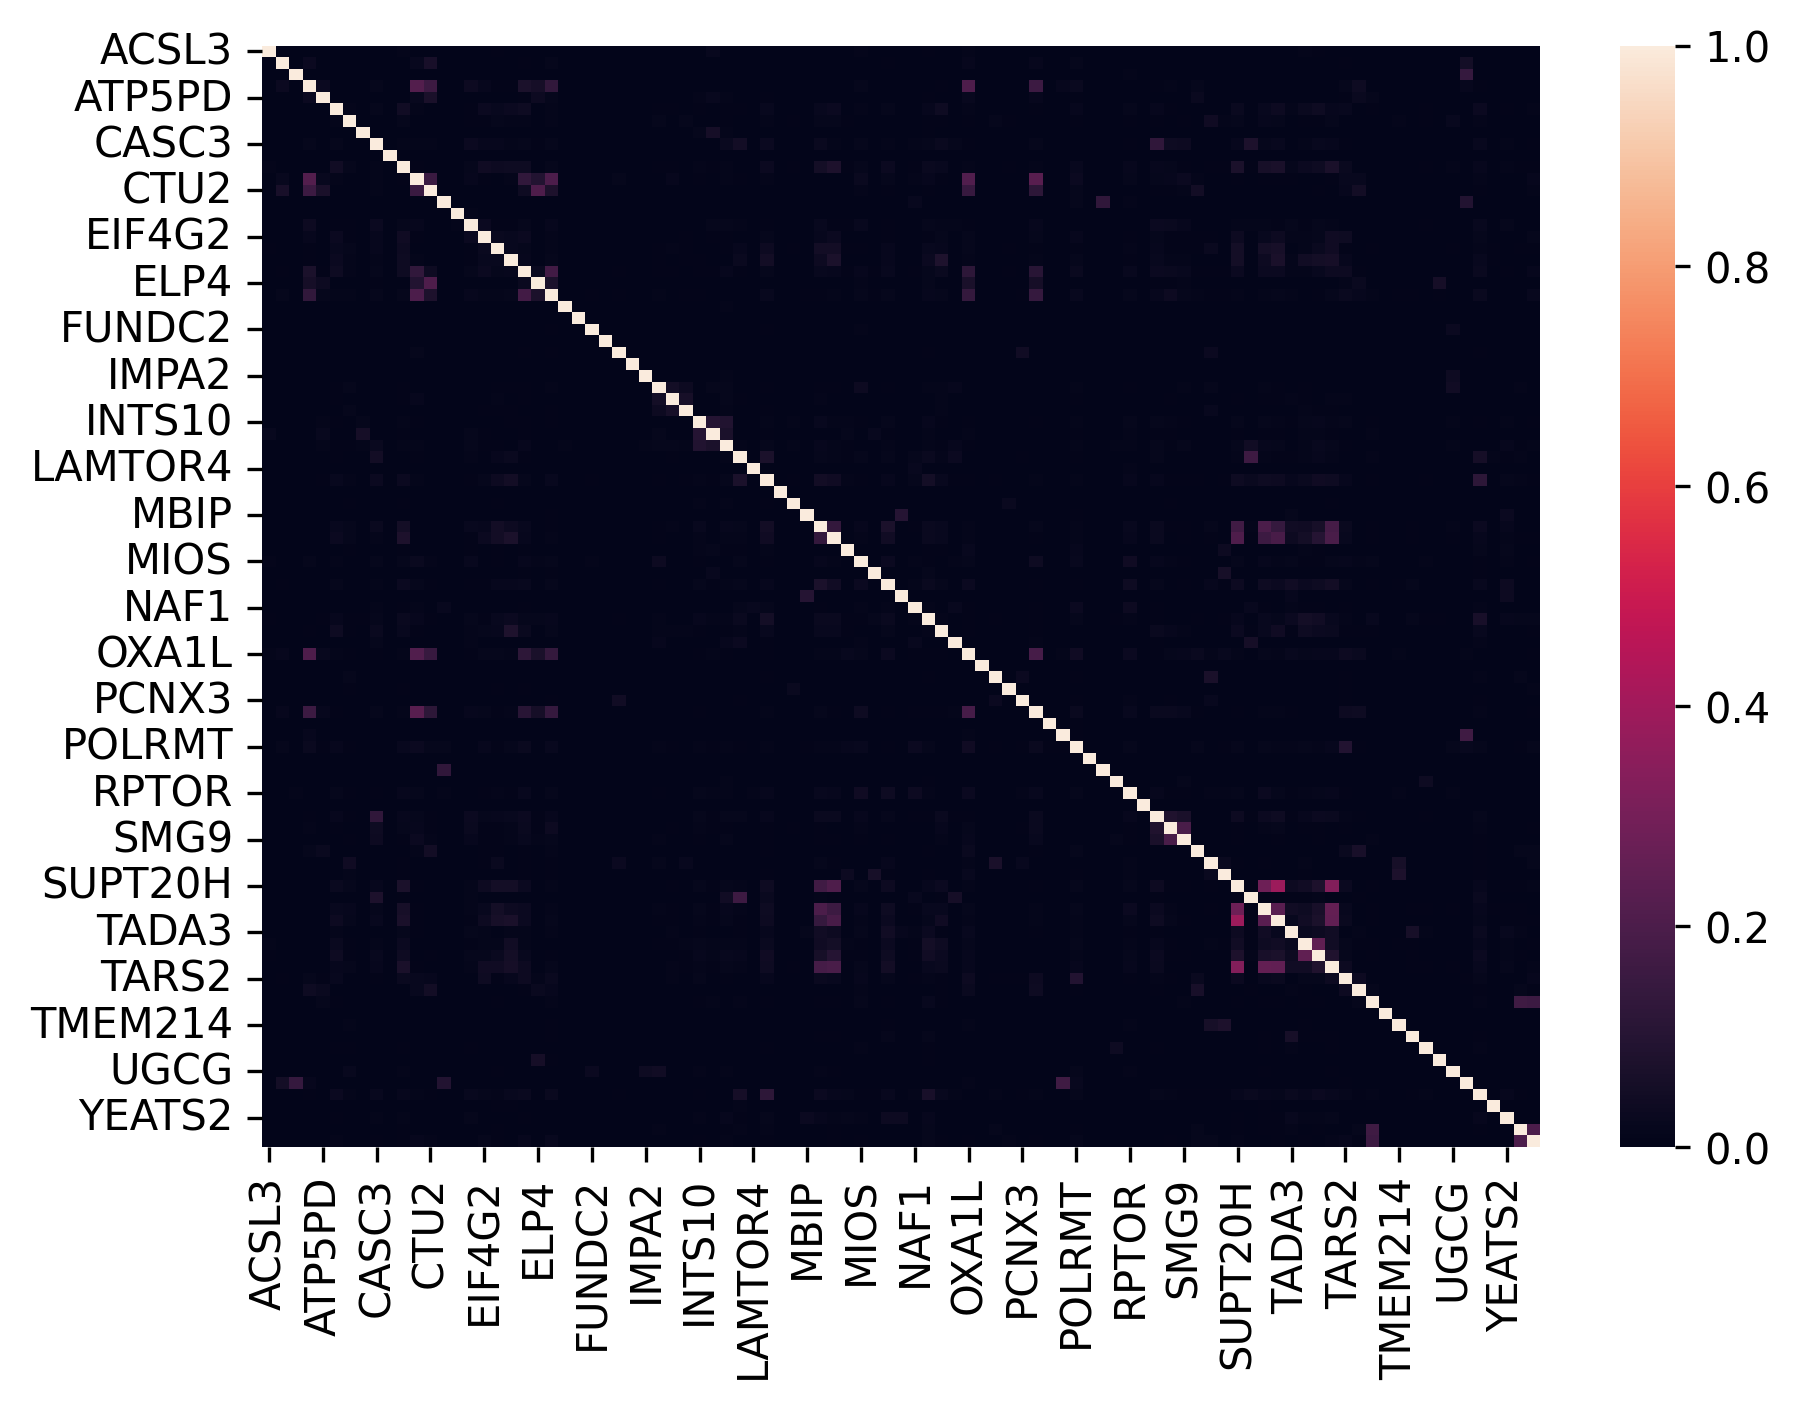

In [162]:
compare_cl_similarity = similarity.copy()
compare_cl_similarity.index = similarity.index.str.split('_').str[1]
compare_cl_similarity.columns = similarity.columns.str.split('_').str[1]

common_perts = np.intersect1d(replogle_perturb_clusters.index, compare_cl_similarity.index)
sns.heatmap(compare_cl_similarity.loc[common_perts, common_perts])

<Axes: >

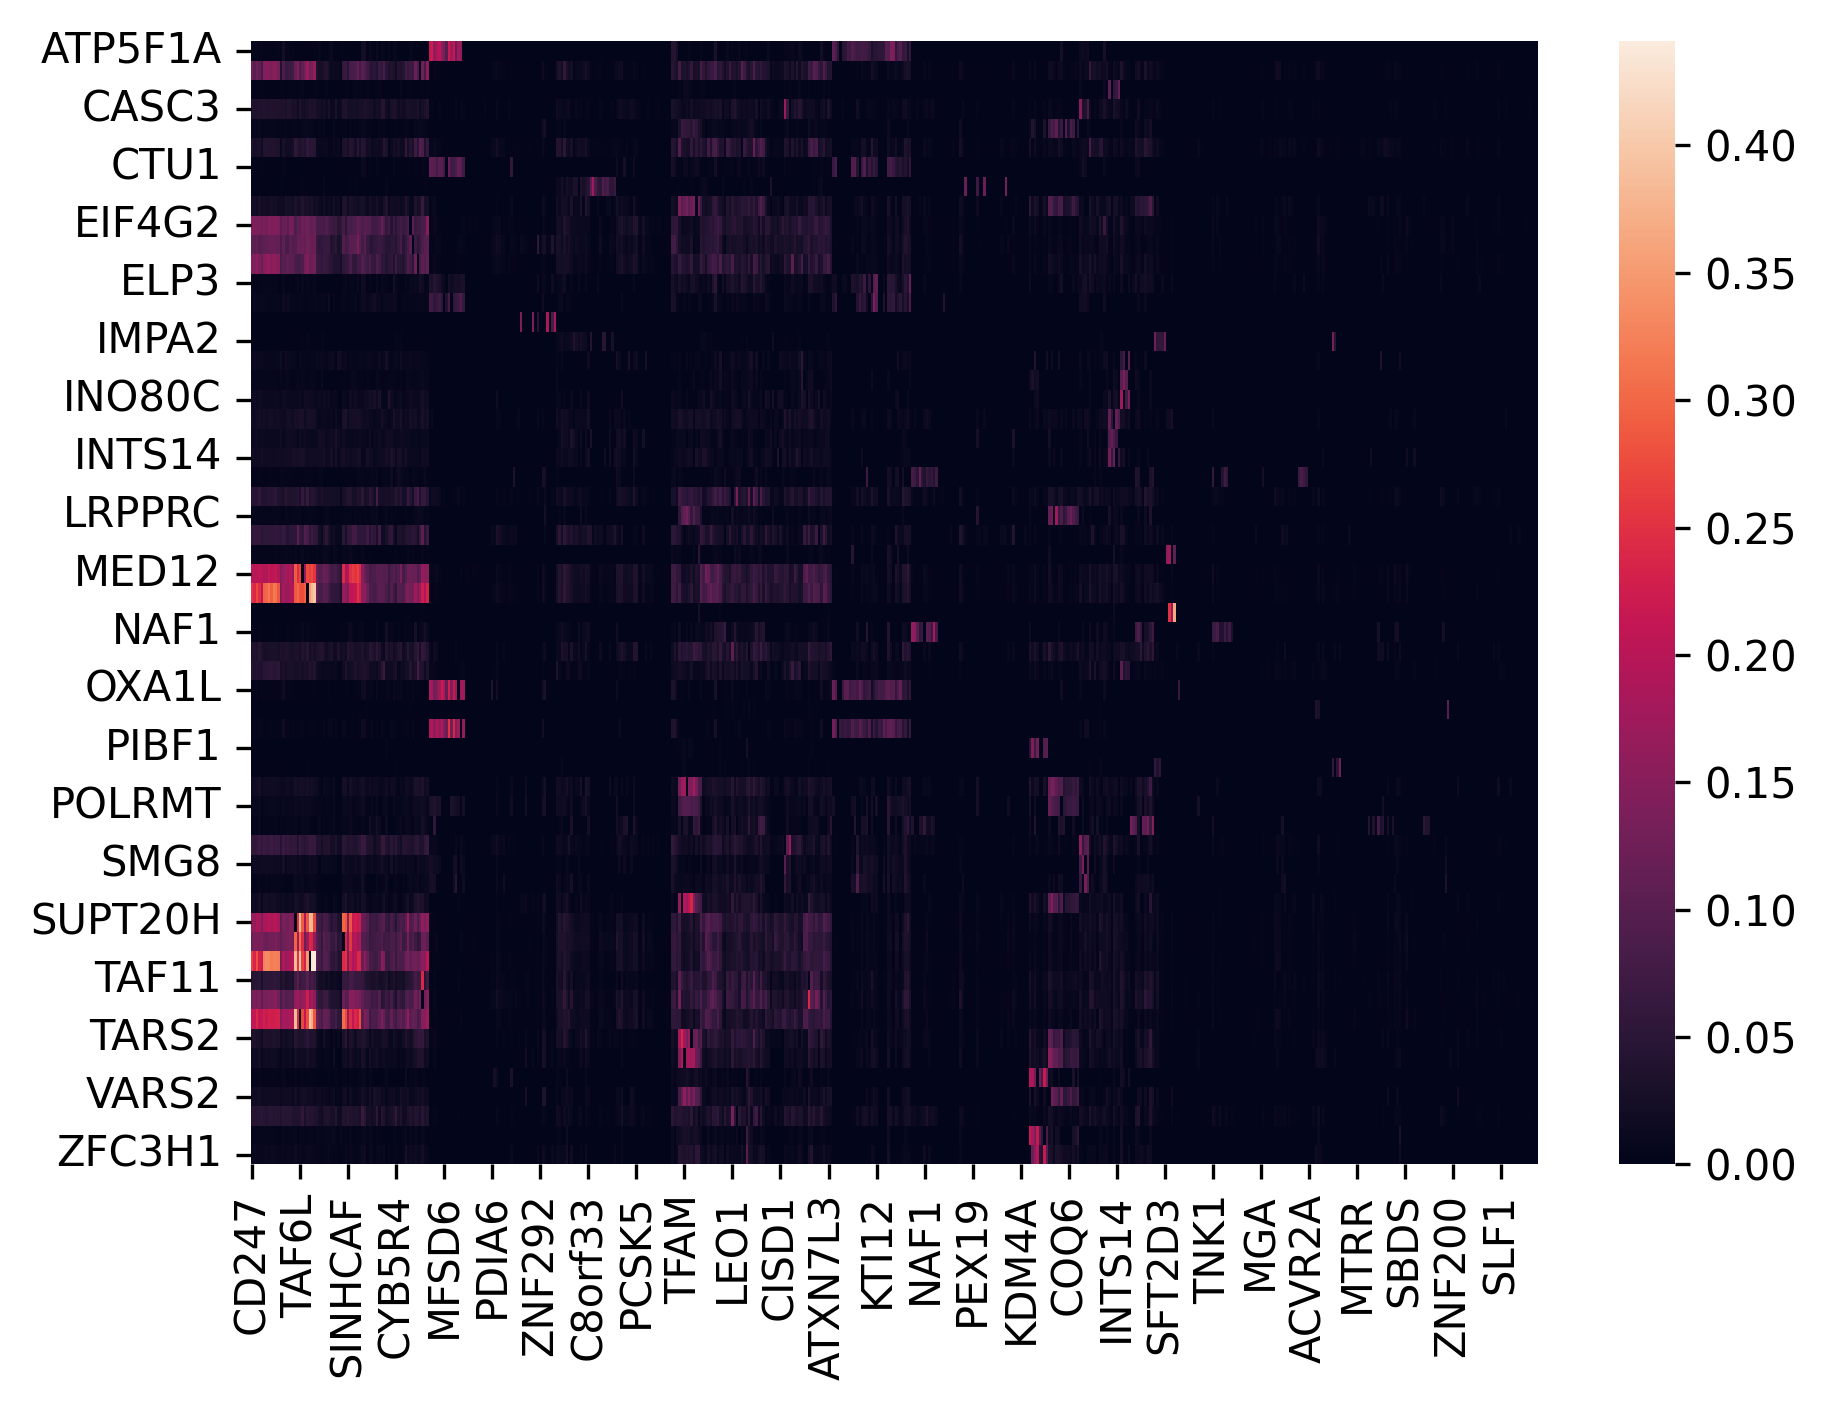

In [122]:
compare_cl_similarity = reordered_data.copy()
compare_cl_similarity.index = reordered_data.index.str.split('_').str[1]
compare_cl_similarity.columns = reordered_data.columns.str.split('_').str[1]

common_perts = np.intersect1d(compare_cl_similarity.index, same_cluster_replogle.index)
compare_cl_similarity.index

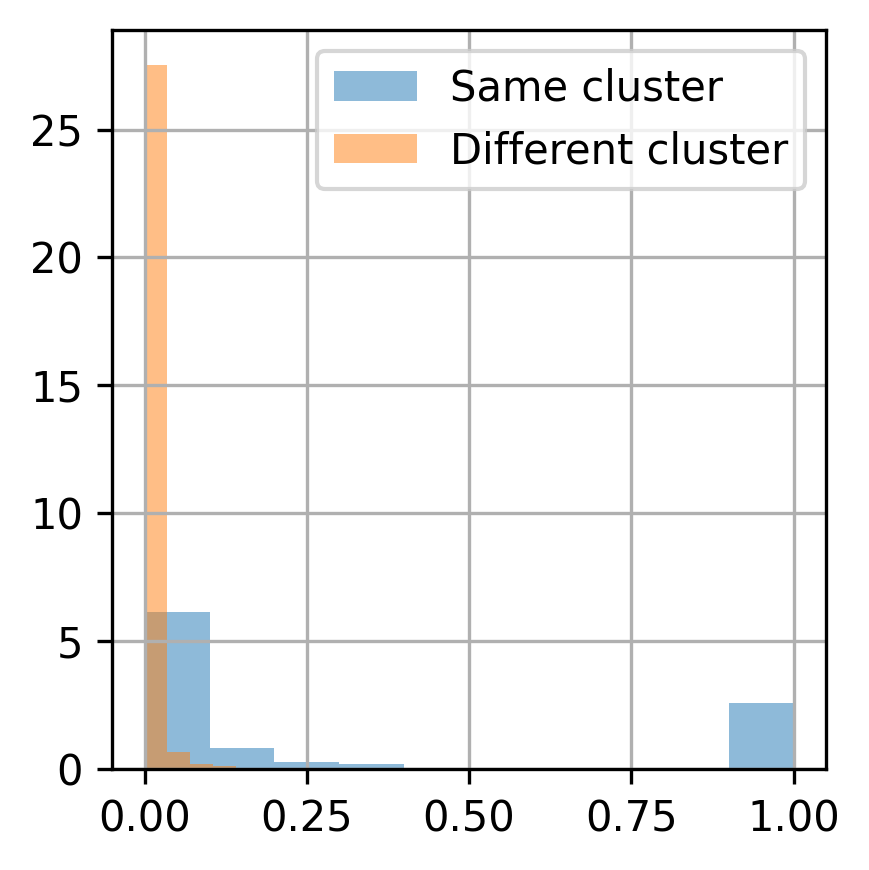

In [112]:
common_perts = np.intersect1d(compare_cl_similarity.index, same_cluster_replogle.index)
plt.figure(figsize=(3,3))
# Get values for both conditions
same_cluster = compare_cl_similarity.loc[common_perts, common_perts][same_cluster_replogle.loc[common_perts, common_perts] > 0].melt().dropna()['value']
diff_cluster = compare_cl_similarity.loc[common_perts, common_perts][same_cluster_replogle.loc[common_perts, common_perts] == 0].melt().dropna()['value']

# Plot normalized histograms by setting density=True
same_cluster.hist(density=True, alpha=0.5, label='Same cluster')
diff_cluster.hist(density=True, alpha=0.5, label='Different cluster')
plt.legend()

gene     ACSL3  ALG2  ANKRD39  ATP5F1A  ATP5PD  BRD8  C16orf87  C7orf26  \
gene                                                                      
ACSL3        1     0        1        0       0     0         0        0   
ALG2         0     1        0        0       0     0         0        0   
ANKRD39      1     0        1        0       0     0         0        0   
ATP5F1A      0     0        0        1       1     0         0        0   
ATP5PD       0     0        0        1       1     0         0        0   
...        ...   ...      ...      ...     ...   ...       ...      ...   
WDR7         0     0        0        0       0     0         0        0   
YARS2        0     0        0        0       0     0         0        0   
YEATS2       0     0        0        0       0     0         0        0   
ZC3H3        0     0        0        0       0     0         0        0   
ZFC3H1       0     0        0        0       0     0         0        0   

gene     CASC3  CLOCK  ...  UBE2I  UBE3C  UGCG  VARS2  WDR61  WDR7  YARS2  \
gene                   ...                                                  
ACSL3        0      0  ...      0      0     0      0      0     0      0   
ALG2         0      0  ...      0      0     0      0      0     0      0   
ANKRD39      0      0  ...      0      0     0      0      0     0      0   
ATP5F1A      0      0  ...      0      0     0      0      0     0      0   
ATP5PD       0      0  ...      0      0     0      0      0     0      0   
...        ...    ...  ...    ...    ...   ...    ...    ...   ...    ...   
WDR7         0      0  ...      0      0     0      0      0     1      0   
YARS2        0      0  ...      0      0     0      1      0     0      1   
YEATS2       0      0  ...      0      0     0      0      0     0      0   
ZC3H3        0      0  ...      0      0     0      0      0     0      0   
ZFC3H1       0      0  ...      0      0     0      0      0     0      0   

gene     YEATS2  ZC3H3  ZFC3H1  
gene                            
ACSL3         0      0       0  
ALG2          0      0       0  
ANKRD39       0      0       0  
ATP5F1A       0      0       0  
ATP5PD        0      0       0  
...         ...    ...     ...  
WDR7          0      0       0  
YARS2         0      0       0  
YEATS2        1      0       0  
ZC3H3         0      1       1  
ZFC3H1        0      1       1  

[118 rows x 118 columns]

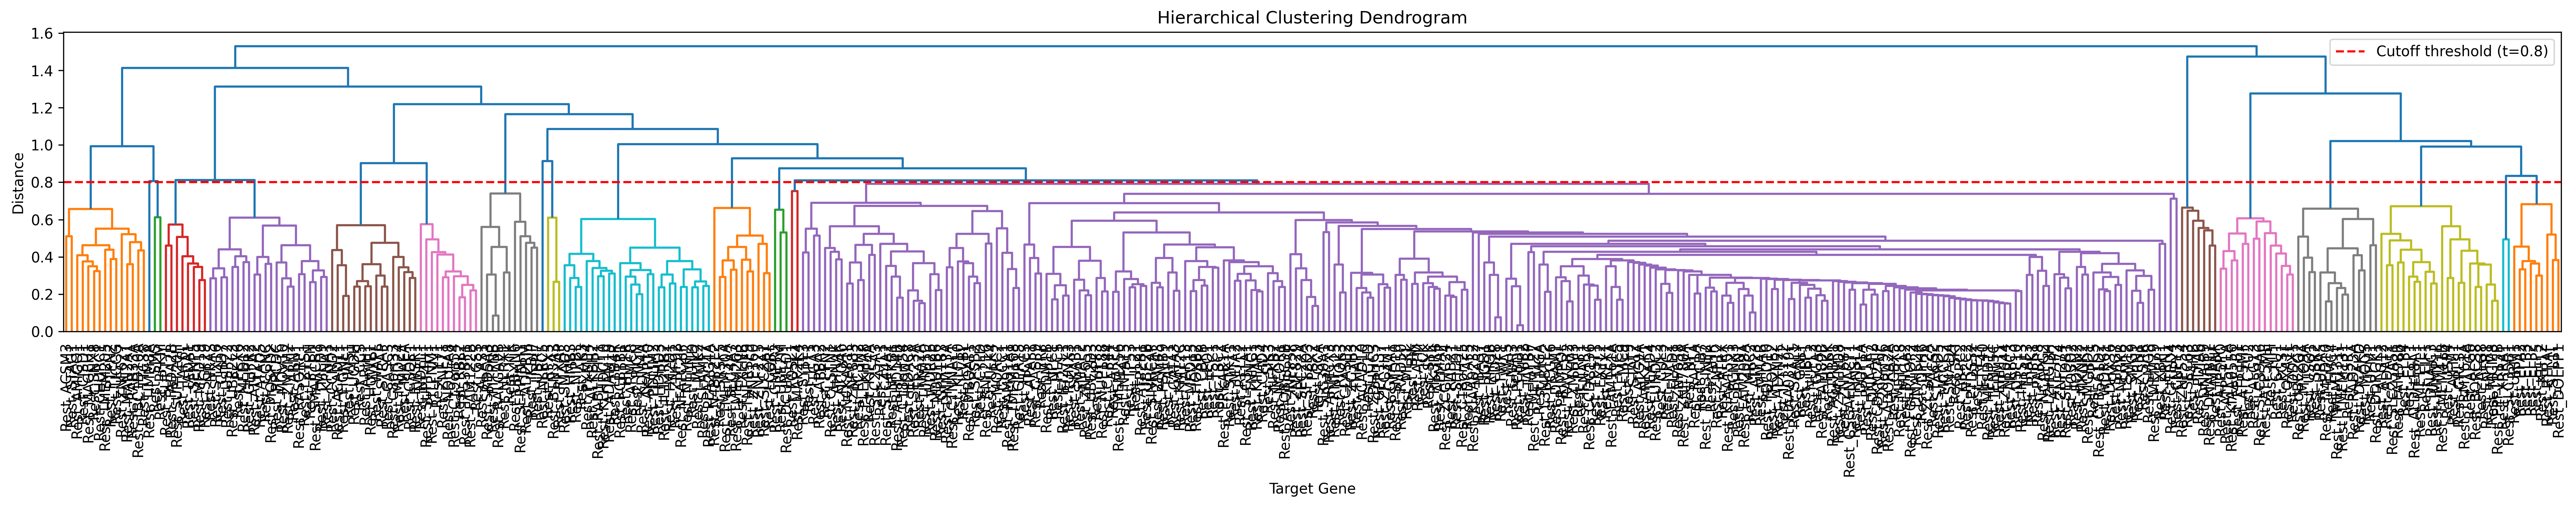

In [165]:
# Extract the clusters from the dendrogram
row_linkage = clustermap.dendrogram_row.linkage

# Plot the dendrogram separately to visualize the clustering

cutoff = 0.8
# Get the gene names for the filtered genes
filtered_genes = ordered_data.index.tolist()
# Create the dendrogram with gene names as labels
plt.figure(figsize=(25,5))
dendrogram = cluster.hierarchy.dendrogram(
    row_linkage, 
    color_threshold=cutoff,
    labels=filtered_genes
)
plt.axhline(y=cutoff, color='r', linestyle='--', label=f'Cutoff threshold (t={cutoff})')
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Target Gene')
plt.ylabel('Distance')
plt.legend()
plt.xticks(rotation=90, fontsize=10)  # Rotate labels for better readability
plt.tight_layout()
plt.show()

# Apply clustering with the chosen cutoff
row_clusters = cluster.hierarchy.fcluster(row_linkage, t=cutoff, criterion='distance')

# Create a dictionary mapping cluster IDs to gene names
cluster_dict = {}
filtered_genes = ordered_data.loc[shared_effects.sum(1) > 5].index
for i, gene in enumerate(filtered_genes):
    cluster_id = row_clusters[i]
    if cluster_id not in cluster_dict:
        cluster_dict[cluster_id] = []
    cluster_dict[cluster_id].append(gene)

In [48]:
suspects = de_counts[de_counts['offtarget_flag']]['target_name'].unique().tolist()

In [49]:
# Create a list of tuples with (gene, cluster_id) pairs
cluster_assignments = []
for cluster_id, genes in cluster_dict.items():
    for gene in genes:
        cluster_assignments.append((gene, cluster_id))

# Convert to DataFrame
cluster_df = pd.DataFrame(cluster_assignments, columns=['target_gene', 'cluster_id'])

# Sort by cluster_id and then by gene name for better readability
cluster_df = cluster_df.sort_values(['cluster_id', 'target_gene'])

cluster_df

target_gene  cluster_id
195   Stim8hr_BTN3A1           1
196    Stim8hr_PTGDR           1
197   Stim8hr_SLC7A7           1
83    Stim8hr_FAM69A           2
85     Stim8hr_PCSK5           2
..               ...         ...
44     Stim8hr_SGF29          23
45   Stim8hr_SINHCAF          23
42     Stim8hr_STX16          23
41     Stim8hr_TADA1          23
38    Stim8hr_UBE2L3          23

[200 rows x 2 columns]

Text(87.73878205128206, 0.5, 'Target gene')

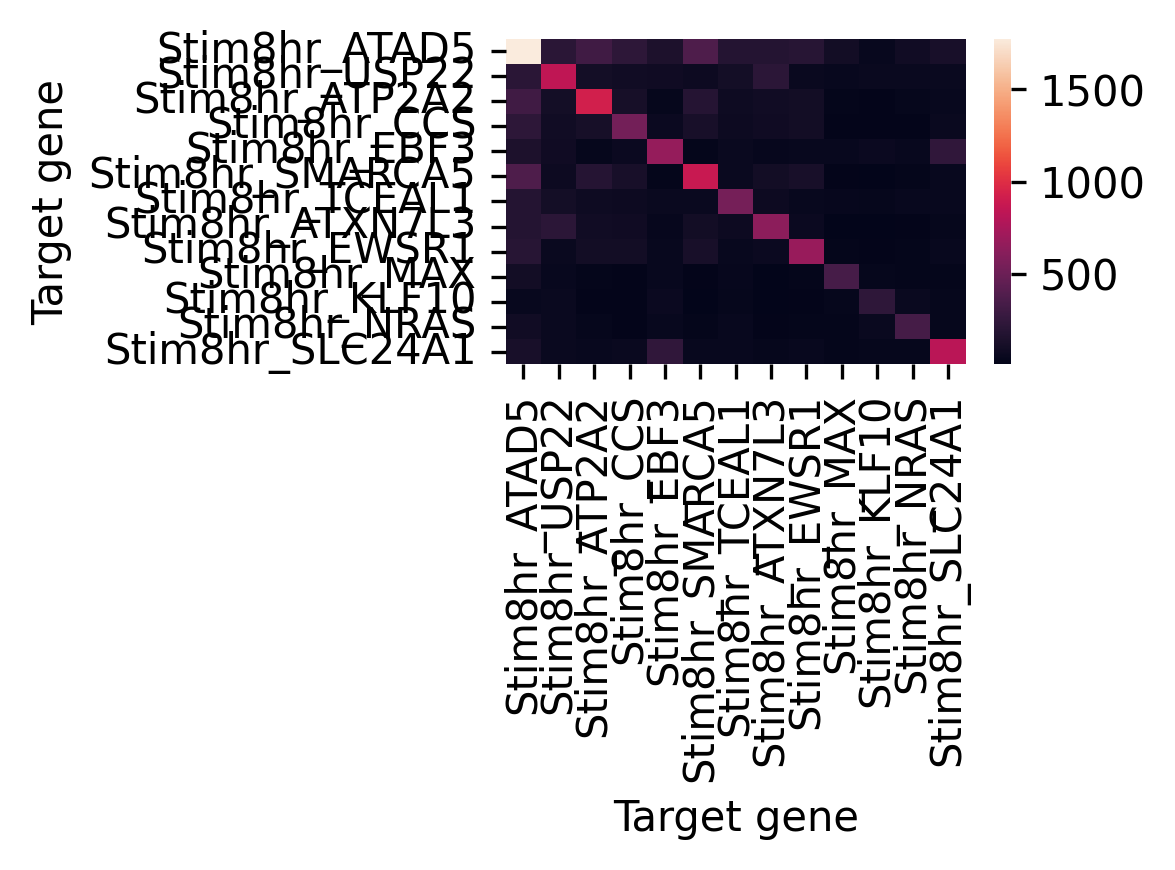

In [50]:
plt.figure(figsize = (4,3));
cl = 7
sns.heatmap(shared_effects.loc[cluster_dict[cl], cluster_dict[cl]], annot=False)
# Add proper axis labels to the main heatmap
plt.xlabel('Target gene')
plt.ylabel('Target gene')
# plt.title('N shared DE genes\n')

In [297]:
import gseapy as gp

def parse_gene_sets(filename):
   gene_sets = {}
   with open(filename, 'r') as f:
       for line in f:
           terms = line.strip().split('\t')
           gene_sets[terms[0]] = terms[2:]
   return gene_sets

OAKPATH = '/mnt/oak/'
# KEGG_sets = parse_gene_sets(f'{OAKPATH}/users/emma/data//KEGG_2019_Human.txt')
GO_BP_sets = parse_gene_sets(f'{OAKPATH}/users/emma/data/GO_Biological_Process_2023.txt')
GENESETS = {**GO_BP_sets}

# gl = cluster_dict[cl]
# background = adata_de.obs['target_contrast_gene_name'].unique().tolist()
background = shared_effects.index.tolist()

# # run enrichr
enr = gp.enrichr(gene_list=cluster_dict[cl],
                gene_sets=GENESETS,
                organism='Human', 
                background=background,
                outdir=None,
                no_plot=True
                )

enr.results[0:10]

Gene_set                                               Term Overlap  \
0  gs_ind_0  Antigen Receptor-Mediated Signaling Pathway (G...    1/36   
1  gs_ind_0                 Inflammatory Response (GO:0006954)    1/38   
2  gs_ind_0  Negative Regulation Of DNA-templated Transcrip...   1/238   
3  gs_ind_0  Negative Regulation Of Hematopoietic Progenito...     1/4   
4  gs_ind_0  Negative Regulation Of Stem Cell Differentiati...     1/5   
5  gs_ind_0  Negative Regulation Of Transcription By RNA Po...   1/181   
6  gs_ind_0  Positive Regulation Of Cytokine Production (GO...    1/74   
7  gs_ind_0  Positive Regulation Of Gene Expression (GO:001...    1/79   
8  gs_ind_0  Positive Regulation Of Multicellular Organisma...    1/76   
9  gs_ind_0  Positive Regulation Of Stem Cell Proliferation...     1/2   

    P-value  Adjusted P-value   Odds Ratio  Combined Score    Genes  
0  0.036057          0.064658    49.394366      164.120996   BTN3A1  
1  0.038034          0.064658    46.728000      152.766813    PTGDR  
2  0.222410          0.236311     6.872842       10.331484  N4BP2L2  
3  0.004050          0.017206   506.485714     2790.256157  N4BP2L2  
4  0.005061          0.017206   393.800000     2081.723915  N4BP2L2  
5  0.172512          0.209479     9.232687       16.224506  N4BP2L2  
6  0.073165          0.101968    23.546939       61.576231   BTN3A1  
7  0.077975          0.101968    22.008917       56.152746   BTN3A1  
8  0.075091          0.101968    22.907285       59.308226   BTN3A1  
9  0.002026          0.017206  1182.600000     7333.921203  N4BP2L2

In [298]:
cluster_dict[cl]

['PTGDR', 'N4BP2L2', 'BTN3A1']

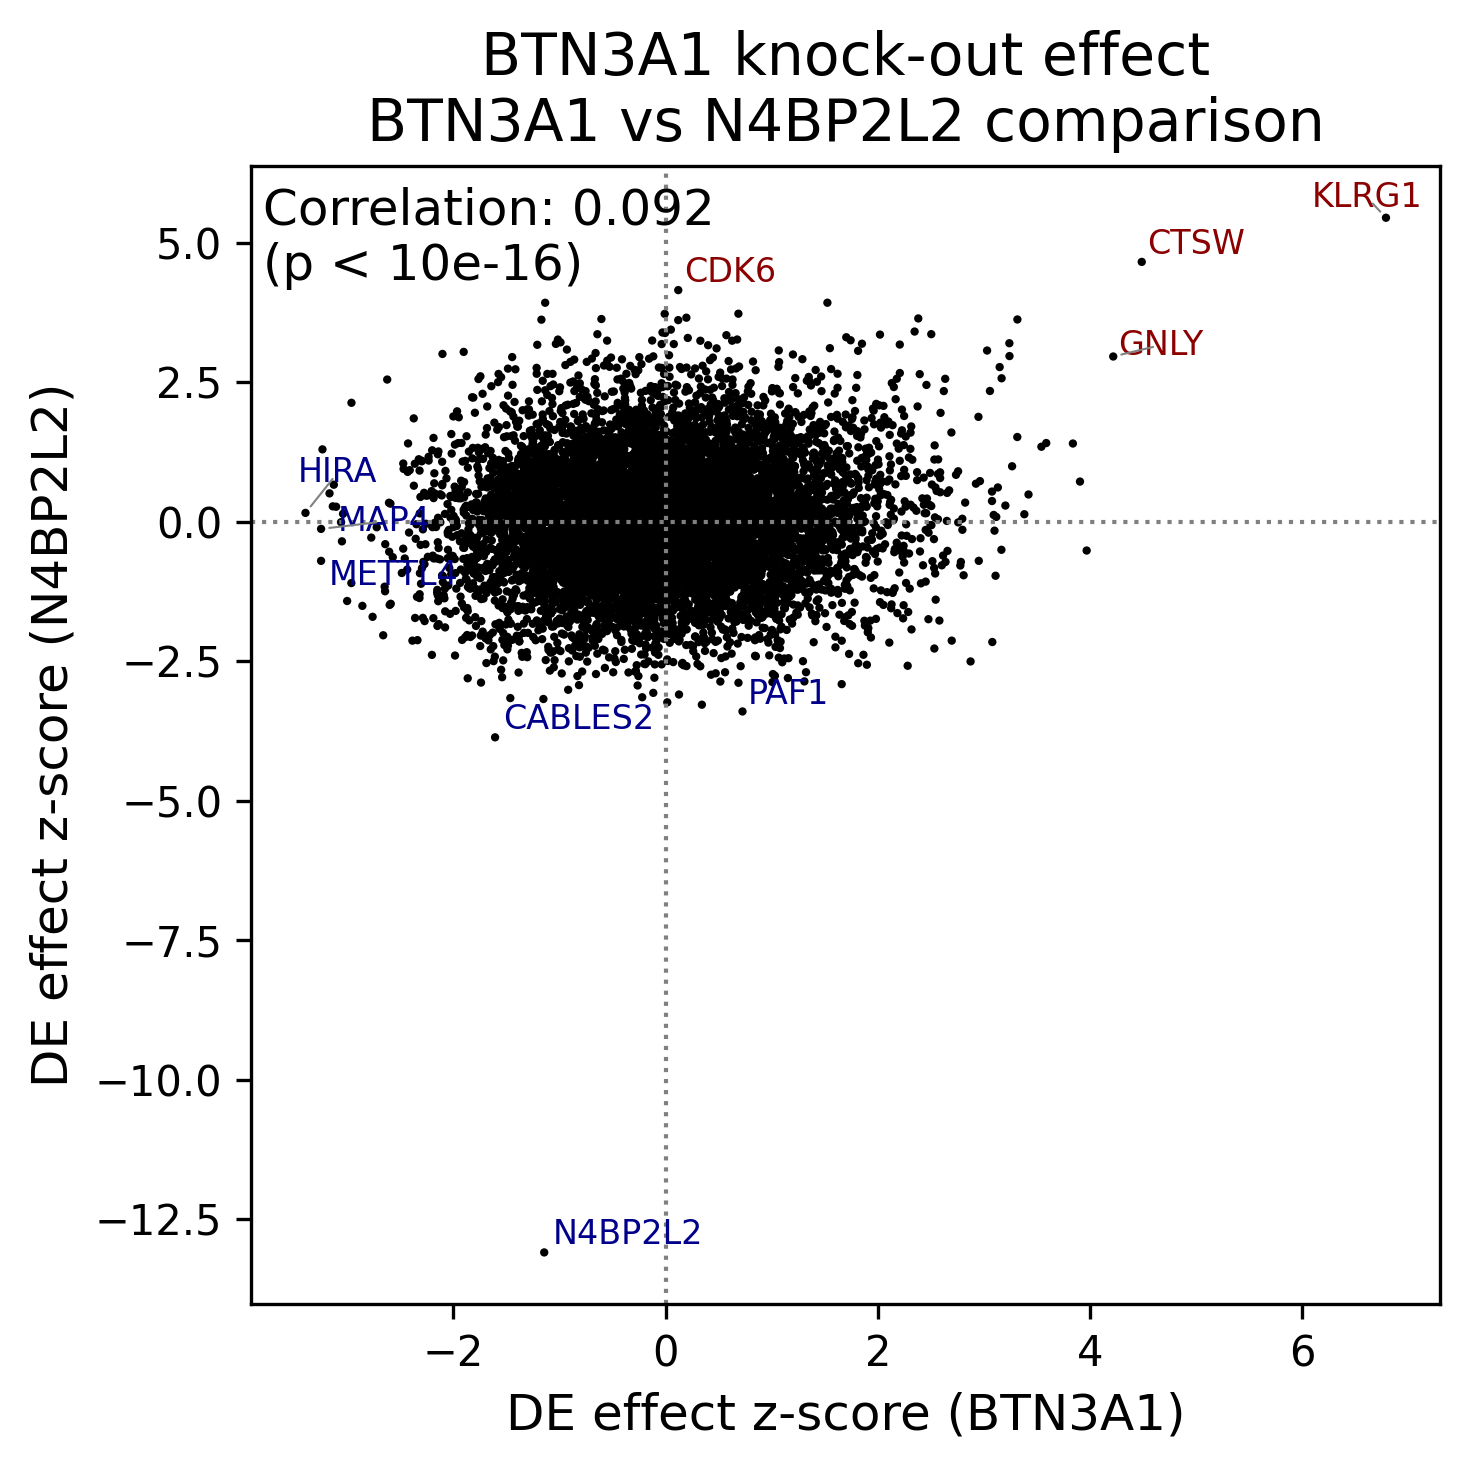

In [299]:
adata_de.var_names = adata_de.var['gene_name'].values

fig, axs = plt.subplots(figsize=(5,5))
res = plot_effect_comparison(
    adata_de, 
    comparison_params = {
        'target_contrast_gene_name':[ 'BTN3A1','N4BP2L2'],
        'culture_condition':['Stim8hr'],
        'stat':['zscore']
    },
    n_top_genes=3,
    plot_correlation=True,
    axis_label = 'DE effect z-score',
    corr_coords_xy = (0.01, 0.90),
    ax=axs
    )
    

In [42]:
# Compute long format for shared effects
long_shared_effects = shared_effects.reset_index().melt(
    id_vars=['target_contrast_gene_name'], 
    value_name='n_shared_effects',
    var_name='target_contrast_gene_name_2'
).sort_values('n_shared_effects', ascending=False)

# Remove self-comparisons
long_shared_effects = long_shared_effects[
    long_shared_effects['target_contrast_gene_name'] != long_shared_effects['target_contrast_gene_name_2']
]

# Compute long format for Jaccard index
long_jaccard_index = filtered_data.reset_index().melt(
    id_vars=['target_contrast_gene_name'],
    value_name='jaccard_index', 
    var_name='target_contrast_gene_name_2'
).sort_values('jaccard_index', ascending=False)

# Remove self-comparisons
long_jaccard_index = long_jaccard_index[
    long_jaccard_index['target_contrast_gene_name'] != long_jaccard_index['target_contrast_gene_name_2']
]

# Filter for at least some shared DE genes
long_jaccard_index = long_jaccard_index[long_jaccard_index.jaccard_index != 0].copy()

# Merge shared effects with Jaccard index
long_jaccard_index = long_jaccard_index.merge(
    long_shared_effects,
    on=['target_contrast_gene_name', 'target_contrast_gene_name_2'],
    how='left'
)

# Merge cluster information for both genes
long_jaccard_index = long_jaccard_index.merge(
    cluster_df.rename(columns={'target_gene': 'target_contrast_gene_name', 'cluster_id': 'cluster_id_1'}),
    on='target_contrast_gene_name',
    how='left'
).merge(
    cluster_df.rename(columns={'target_gene': 'target_contrast_gene_name_2', 'cluster_id': 'cluster_id_2'}),
    on='target_contrast_gene_name_2',
    how='left'
)

# Add column indicating if genes are in same cluster
long_jaccard_index['same_cluster'] = long_jaccard_index['cluster_id_1'] == long_jaccard_index['cluster_id_2']

# Keep only the first occurrence of each gene pair
long_jaccard_index['gene_pair'] = long_jaccard_index.apply(
    lambda x: tuple(sorted([x['target_contrast_gene_name'], x['target_contrast_gene_name_2']])), 
    axis=1
)

long_jaccard_index = long_jaccard_index.drop_duplicates(subset='gene_pair')
long_jaccard_index['gene_pair'] = long_jaccard_index['gene_pair'].apply(lambda x: ' - '.join(x))


KeyError: "The following id_vars or value_vars are not present in the DataFrame: ['target_contrast_gene_name']"

In [46]:
print(datadir)

/mnt/oak/users/emma/data/GWT/CD4iR1_Psomagen/


## Comparison with Replogle et al 2022

In [78]:
replogle_df = pd.read_csv('/Users/rzhu/Gladstone Dropbox/Ronghui Zhu/GRNPerturbSeq/2_files/Replogle_et_al_2022/perturbation_clusters.csv', index_col=0)

In [81]:
replogle_df.members

0                            AMMECR1,RAB4B,RNF11,SH3GL1
1                 ZNF326,COX6B1,COA8,SETX,SLC12A5,SPRY4
2     RAB5IF,EXOC5,PACS2,RAI14,SKIL,STARD10,ELOB,C16...
3                         DCAF11,HIPK3,NPC1,OXCT1,SYNJ2
4               ZC3H13,CBLL1,METTL14,METTL3,PSMG1,RBM15
                            ...                        
59    ACSS2,CEBPG,LRPPRC,MTPAP,PNPT1,POLRMT,SSBP1,TE...
60    CD3EAP,HEATR1,NOL11,POLR1A,POLR1B,POLR1C,POLR1...
61    CARF,CCDC86,DDX24,DDX51,DDX56,EIF6,ABCF1,GNL2,...
62    AARS,CHCHD4,DNAJA3,DNAJC19,EIF2B1,EIF2B2,EIF2B...
63                          MRPS21,MRPS23,MRPS28,MRPS35
Name: members, Length: 64, dtype: object

In [84]:
replogle_genes = []

# Iterate through each entry in the Series
for member_string in replogle_df.members:
    # Split the string by ', ' to get individual gene names
    genes = [gene.strip() for gene in member_string.split(',')]
    # Extend the long_list_of_genes with the extracted names
    replogle_genes.extend(genes)

In [87]:
gene_all = sgRNA.corrected_target_gene_name
two_donor_genes = adata_de.obs.target_contrast_gene_name.values
four_donor_genes = DE_obs.perturbed_gene_name

In [89]:
len(set(replogle_genes) & set(gene_all)) / len(gene_all)

0.026379742866102226

In [90]:
len(set(replogle_genes) & set(two_donor_genes)) / len(two_donor_genes)

0.01175262437243268

In [98]:
len(set(replogle_genes) & set(two_donor_genes)) / len(replogle_genes)

0.29219858156028367

In [99]:
len(set(replogle_genes) - set(two_donor_genes)) / len(replogle_genes)

0.7049645390070922

In [100]:
len(set(replogle_genes) & set(four_donor_genes)) / len(replogle_genes)

0.4879432624113475

In [101]:
len(set(replogle_genes) - set(four_donor_genes)) / len(replogle_genes)

0.5092198581560283

In [147]:
perturbation_counts = pd.read_csv('/Users/rzhu/Gladstone Dropbox/Ronghui Zhu/GRNPerturbSeq/3_expts/processed_data/CD4iR1_Psomagen/perturbation_counts.csv')
sgRNA_dist = pd.DataFrame({'gene': perturbation_counts.guide_id.str[:-2], 'count': np.sum(perturbation_counts.iloc[:,1:], axis=1)})
sgRNA_dist = sgRNA_dist.groupby('gene')['count'].sum().reset_index()

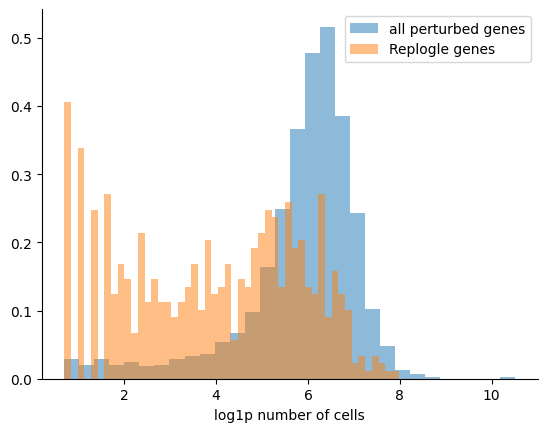

In [159]:
plt.hist(np.log1p(sgRNA_dist['count'].values), bins=30, density=True, alpha=0.5)
plt.hist(np.log1p(sgRNA_dist.loc[sgRNA_dist.gene.isin(replogle_genes), 'count']), bins=50, density=True, alpha=0.5)
plt.legend(['all perturbed genes', 'Replogle genes'])
plt.xlabel('log1p number of cells')
sns.despine()

In [160]:
DE_obs

10xrun_id       cell_sample_id   donor_id  \
CD4i_R2_D1_Stim48hr_A1BG-1   CD4i_R2  CD4i_R2_D1_Stim48hr  CE0008162   
CD4i_R2_D1_Stim48hr_A1BG-2   CD4i_R2  CD4i_R2_D1_Stim48hr  CE0008162   
CD4i_R2_D1_Stim48hr_A2M-2    CD4i_R2  CD4i_R2_D1_Stim48hr  CE0008162   
CD4i_R2_D1_Stim48hr_AAAS-1   CD4i_R2  CD4i_R2_D1_Stim48hr  CE0008162   
CD4i_R2_D1_Stim48hr_AACS-1   CD4i_R2  CD4i_R2_D1_Stim48hr  CE0008162   
...                              ...                  ...        ...   
CD4i_R2_D4_Rest_ZYG11B-2     CD4i_R2      CD4i_R2_D4_Rest  CE0006864   
CD4i_R2_D4_Rest_ZYX-2        CD4i_R2      CD4i_R2_D4_Rest  CE0006864   
CD4i_R2_D4_Rest_ZYX-3        CD4i_R2      CD4i_R2_D4_Rest  CE0006864   
CD4i_R2_D4_Rest_ZZEF1-1      CD4i_R2      CD4i_R2_D4_Rest  CE0006864   
CD4i_R2_D4_Rest_ZZEF1-2      CD4i_R2      CD4i_R2_D4_Rest  CE0006864   

                           culture_condition  guide_id perturbed_gene_name  \
CD4i_R2_D1_Stim48hr_A1BG-1          Stim48hr    A1BG-1                A1BG   
CD4i_R2_D1_Stim48hr_A1BG-2          Stim48hr    A1BG-2                A1BG   
CD4i_R2_D1_Stim48hr_A2M-2           Stim48hr     A2M-2                 A2M   
CD4i_R2_D1_Stim48hr_AAAS-1          Stim48hr    AAAS-1                AAAS   
CD4i_R2_D1_Stim48hr_AACS-1          Stim48hr    AACS-1                AACS   
...                                      ...       ...                 ...   
CD4i_R2_D4_Rest_ZYG11B-2                Rest  ZYG11B-2              ZYG11B   
CD4i_R2_D4_Rest_ZYX-2                   Rest     ZYX-2                 ZYX   
CD4i_R2_D4_Rest_ZYX-3                   Rest     ZYX-3                 ZYX   
CD4i_R2_D4_Rest_ZZEF1-1                 Rest   ZZEF1-1               ZZEF1   
CD4i_R2_D4_Rest_ZZEF1-2                 Rest   ZZEF1-2               ZZEF1   

                           perturbed_gene_id guide_type  n_cells  \
CD4i_R2_D1_Stim48hr_A1BG-1   ENSG00000121410  targeting     26.0   
CD4i_R2_D1_Stim48hr_A1BG-2   ENSG00000121410  targeting    160.0   
CD4i_R2_D1_Stim48hr_A2M-2    ENSG00000175899  targeting     22.0   
CD4i_R2_D1_Stim48hr_AAAS-1   ENSG00000094914  targeting     95.0   
CD4i_R2_D1_Stim48hr_AACS-1   ENSG00000081760  targeting     73.0   
...                                      ...        ...      ...   
CD4i_R2_D4_Rest_ZYG11B-2     ENSG00000162378  targeting      8.0   
CD4i_R2_D4_Rest_ZYX-2        ENSG00000159840  targeting     39.0   
CD4i_R2_D4_Rest_ZYX-3        ENSG00000159840  targeting     31.0   
CD4i_R2_D4_Rest_ZZEF1-1      ENSG00000074755  targeting    100.0   
CD4i_R2_D4_Rest_ZZEF1-2      ENSG00000074755  targeting     55.0   

                            total_counts  keep_min_cells  \
CD4i_R2_D1_Stim48hr_A1BG-1      326500.0            True   
CD4i_R2_D1_Stim48hr_A1BG-2     2313880.0            True   
CD4i_R2_D1_Stim48hr_A2M-2       330204.0            True   
CD4i_R2_D1_Stim48hr_AAAS-1     1389867.0            True   
CD4i_R2_D1_Stim48hr_AACS-1     1064913.0            True   
...                                  ...             ...   
CD4i_R2_D4_Rest_ZYG11B-2         66171.0            True   
CD4i_R2_D4_Rest_ZYX-2           318693.0            True   
CD4i_R2_D4_Rest_ZYX-3           247297.0            True   
CD4i_R2_D4_Rest_ZZEF1-1        1050023.0            True   
CD4i_R2_D4_Rest_ZZEF1-2         405467.0            True   

                            keep_effective_guides  keep_total_counts  \
CD4i_R2_D1_Stim48hr_A1BG-1                   True               True   
CD4i_R2_D1_Stim48hr_A1BG-2                   True               True   
CD4i_R2_D1_Stim48hr_A2M-2                    True               True   
CD4i_R2_D1_Stim48hr_AAAS-1                   True               True   
CD4i_R2_D1_Stim48hr_AACS-1                   True               True   
...                                           ...                ...   
CD4i_R2_D4_Rest_ZYG11B-2                     True               True   
CD4i_R2_D4_Rest_ZYX-2                        True               True   
CD4i_R2_D4_Rest_ZYX-3                  

In [139]:
sgRNA_dist['count']

0         132.0
1         451.0
2          38.0
3         220.0
4         230.0
          ...  
25114     159.0
25115    1702.0
25116     529.0
25117    1000.0
25118     329.0
Name: count, Length: 25119, dtype: float64